/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Coupling map:


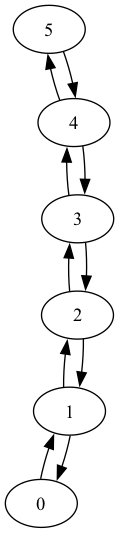

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt
from rl_qoc.helpers.transpiler_passes import CausalConePass

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

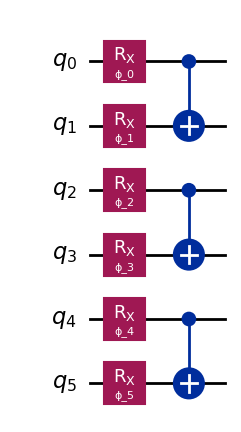

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


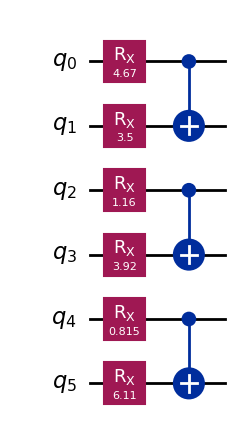

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

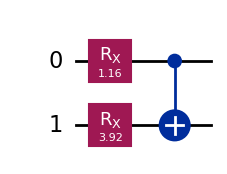

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

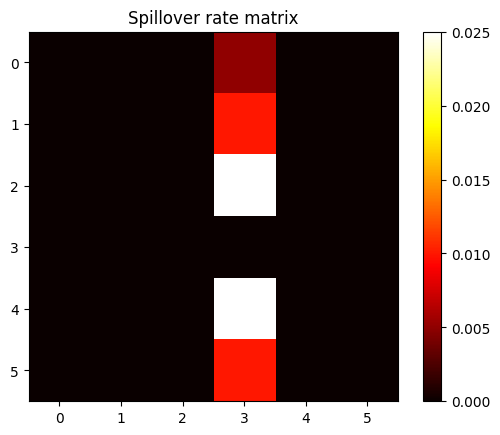

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.0  # γ_0->1
gamma_matrix[0, 3] = 0.005  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[1, 3] = 0.01  # γ_1->3
gamma_matrix[2, 2] = 0.0  # γ_2->2
gamma_matrix[2, 3] = 0.025  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 3] = 0.01  # γ_5->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
# gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)

# Generate another gamma matrix based on coupling map defined above
# gamma_matrix = 0.0 * np.eye(num_qubits)
# for edge in cm.get_edges():
#     gamma_matrix[edge[0], edge[1]] = 0.05


# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [6]:
gamma_matrix

array([[0.   , 0.   , 0.   , 0.005, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.01 , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.01 , 0.   , 0.   ]])

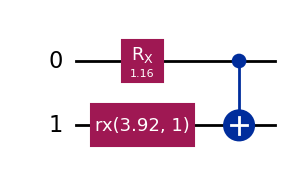

In [7]:
spillover_pass = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
causal_cone_pass = CausalConePass((2, 3))
pm = PassManager([spillover_pass, causal_cone_pass])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = circuit.assign_parameters(param_dict)
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [8]:
qc_noisy.qubits

[Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)]

In [9]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.1607433119572852]), qubits=(Qubit(QuantumRegister(6, 'q'), 2),), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j],
       [ 0.        -0.92432454j, -0.38160732+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 3),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=())]

In [10]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [11]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': 'a4ce1d11863846e0b541e3fda05d0310',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99644118+0.j        , 0.        -0.08429101j],
              [0.        -0.08429101j, 0.99644118+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [12]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager(
    [spillover_pass, causal_cone_pass] + full_pm.translation._tasks[0]
)
full_pm.translation = custom_translation_pass

In [13]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x1535d2450>,

In [14]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [15]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': 'a4ce1d11863846e0b541e3fda05d0310',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99644118+0.j        , 0.        -0.08429101j],
              [0.        -0.08429101j, 0.99644118+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [16]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


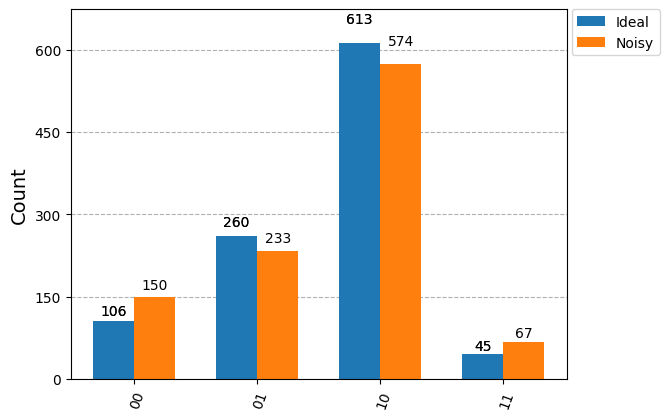

In [17]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [18]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [19]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9943160204742245

In [20]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


# def apply_parametrized_circuit(
#     qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
# ):
#     """
#     Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
#     This function is used to run the QuantumCircuit instance on a Runtime backend
#     :param qc: Quantum Circuit instance to add the gate on
#     :param params: Parameters of the custom Gate
#     :param q_reg: Quantum Register formed of target qubits
#     :return:
#     """
#     target = kwargs["target"]
#     my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
#     optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
#     # optimal_params = np.pi * np.zeros(len(params))
#     new_params = [optimal_params[i] + params[i] for i in range(len(params))]

#     my_qc.u(
#         new_params[0],
#         -np.pi/2,
#         np.pi/2,
#         q_reg[0],
#     )
#     my_qc.u(
#         0.,
#         new_params[1],
#         new_params[2],
#         q_reg[0],
#     )
#     my_qc.u(
#         *new_params[3:6],
#         q_reg[1],
#     )

#     my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

#     qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [21]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-0.20, high=0.20, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[10,],
        n_shots=100,
        sampling_paulis=1000,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

In [22]:
import numpy as np
from typing import Optional, Dict, Any, SupportsFloat
from qiskit import QuantumCircuit
from rl_qoc.environment.context_aware_quantum_environment import (
    ObsType,
    ActType,
    ContextAwareQuantumEnvironment,
)
from gymnasium.spaces import Box
from rl_qoc import ContextAwareQuantumEnvironment, QEnvConfig, GateTarget
from spillover_effect_on_subsystem import (
    noisy_backend,
    circuit_context,
    LocalSpilloverNoiseAerPass,
    numpy_to_hashable,
)
from rl_qoc.helpers import causal_cone_circuit


class GeneralAngleSpilloverEnv(ContextAwareQuantumEnvironment):
    """
    Quantum environment with spillover noise on a subsystem where each epoch will have a random set of angles.
    The input circuit context of this environment is expected to have symbolic Parameters for all rotation axes.
    It also should have the form of one layer of single qubit rotation gates (rx, ry, rz) and a layer of two-qubit gates.
    Binding of those parameters will be done automatically at the reset of the environment.
    """

    def __init__(
        self,
        q_env_config: QEnvConfig,
        unbound_circuit_context: QuantumCircuit,
        gamma_matrix: np.ndarray,
        num_params: int,
        discrete_history_length: int,
        applied_qubits: list,  # list of qubits which we will include the effect of
        circuit_param_distribution: Optional[str] = "uniform",
        optimal_error_precision: Optional[float] = 1e-4,
        obs_bounds: Optional[tuple] = (-np.pi, np.pi),
    ):
        """
        Initialize the environment
        """
        self.num_params = num_params
        self.circuit_param_distribution = circuit_param_distribution
        self.optimal_error_precision = optimal_error_precision
        self.discrete_history_length = discrete_history_length
        self.gamma_matrix = gamma_matrix
        self.circuit_parameters = unbound_circuit_context.parameters

        super().__init__(q_env_config, unbound_circuit_context)
        self._rotation_angles_rng = np.random.default_rng(
            self.np_random.integers(2**32)
        )
        self.observation_space = Box(
            low=np.array([-1.0] * len(applied_qubits)),
            high=np.array([1.0] * len(applied_qubits)),
            dtype=np.float64,
        )
        self.obs_bounds = obs_bounds

        self.discrete_reward_history = np.ones(
            (discrete_history_length, self.num_params)
        )
        self.single_qubit_discrete_obs_vals_raw = np.linspace(
            self.observation_space.low[0], self.observation_space.high[0], self.num_params
        )
        self.discrete_obs_vals_raw = np.linspace(
            self.observation_space.low, self.observation_space.high, self.num_params
        ) #.flatten()
        self.discrete_obs_vals_angles = self.obs_raw_to_angles(self.discrete_obs_vals_raw)
        print(f"Observation Vals for Agent: {self.discrete_obs_vals_raw}")
        print(f"Observation Vals for Env: {self.discrete_obs_vals_angles}")
        self.obs_angles = np.zeros(self.observation_space.shape)
        self.applied_qubits = applied_qubits
        self.prob_weights = np.ones_like(self.single_qubit_discrete_obs_vals_raw)
        self.prob_weights /= len(self.prob_weights)

        self.obs_raw = np.zeros(self.observation_space.shape)

    def obs_raw_to_angles(self, obs_raw):
        # Obs raw between -1. and 1.
        # Angles between self.obs_bounds[0] and self.obs_bounds[1]
        scale = (self.obs_bounds[1] - self.obs_bounds[0]) / 2
        mean = (self.obs_bounds[0] + self.obs_bounds[1]) / 2

        obs_scaled = obs_raw * scale
        angles = obs_scaled + mean
        return angles

    def angles_to_obs_raw(self, angles):
        # Angles between self.obs_bounds[0] and self.obs_bounds[1]
        # Obs raw between -1. and 1.
        scale = (self.obs_bounds[1] - self.obs_bounds[0]) / 2
        mean = (self.obs_bounds[0] + self.obs_bounds[1]) / 2

        obs_scaled = angles - mean
        obs_raw = obs_scaled / scale

        return obs_raw

    def reset(
        self,
        debug_obs: Optional[np.ndarray] = None,
        *,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Any]] = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """
        Reset the environment
        :param seed: Seed for the environment
        :param options: Options for the environment
        :return: Initial observation and info
        """

        # Reset the environment
        old_angles, info = super().reset(seed=seed, options=options)

        if debug_obs is not None:
            self.obs_angles = debug_obs
            self.obs_raw = self.angles_to_obs_raw(self.obs_angles)
        else:
            self.obs_raw = self._get_new_obs_raw()
            self.obs_angles = self.obs_raw_to_angles(self.obs_raw)

        self.phi_vec = np.zeros(self.unbound_circuit_context.num_qubits)
        self.phi_vec[self.applied_qubits] = self.obs_angles

        param_dict = {self.circuit_parameters[i].name: self.phi_vec[i] for i in range(len(self.phi_vec))}
        circuit = self.unbound_circuit_context.assign_parameters(param_dict)
        backend = noisy_backend(
            circuit, self.gamma_matrix, self.config.env_metadata["target_subsystem"]
        )
        # Generate the initial observation
        self.set_circuit_context(None, backend=backend, **param_dict)
        env_obs = self._get_obs()
        print("Sampled angles: ", self.phi_vec)
        print(f"Environment Observation: {env_obs}")
        # Return the initial observation and info
        return env_obs, {}

    def _get_new_obs_raw(self):
        if self.circuit_param_distribution == "uniform":
            obs_raw = np.random.uniform(
                self.observation_space.low,
                self.observation_space.high,
                self.observation_space.shape,
            )
        if self.circuit_param_distribution == "simple_discrete":
            obs_raw = np.random.choice(
                a=self.single_qubit_discrete_obs_vals_raw,
                size=self.observation_space.shape[0],
                replace=True,
            )
            print(obs_raw)
        if self.circuit_param_distribution == "moving_discrete":
            ### Only works for single qubit spillover ###
            self.prob_weights = (
                np.mean(self.discrete_reward_history, axis=0)
                + np.log10(self.optimal_error_precision)
            ) ** 2
            self.prob_weights /= np.sum(self.prob_weights)
            obs_raw = np.random.choice(
                a=self.single_qubit_discrete_obs_vals_raw,
                size=self.observation_space.shape[0], # Will hit error if used for more than single qubit
                replace=True,
                p=self.prob_weights,
            )
        return obs_raw

    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:

        print(f"batch action shape: {action.shape}")

        obs, reward, terminated, truncated, info = super().step(action)
        print(f"obs: {obs}")
        print(f"reward: {reward}")

        if self.circuit_param_distribution == "moving_discrete":
            self.update_discrete_history(reward, obs)

        return obs, reward, terminated, truncated, info

    def update_discrete_history(self, reward, obs):
        obs_ind = np.argmin(np.abs(self.discrete_obs_vals_raw - obs))
        self.discrete_reward_history[:, obs_ind] = np.append(
            [np.mean(reward)], self.discrete_reward_history[:-1, obs_ind], axis=0
        )

    # def initialize_discrete_history(self):
    #     # Initializes Discrete History with success of zeros policy
    #     for set_obs in np.tile(self.discrete_obs_vals, (self.discrete_history_length,)):
    #         _obs, info = self.reset(debug_obs=np.array([set_obs]))
    #         obs, reward, terminated, truncated, info = self.step(np.zeros((self.batch_size,) + self.action_space.shape))

    def clear_history(self):
        super().clear_history()
        self.discrete_reward_history = np.ones_like(self.discrete_reward_history)

    def _get_obs(self):
        """
        Get the observation
        :return: Observation
        """
        return self.obs_raw  # Normalized to multiples of pi

    def _get_info(self) -> Any:
        return {}


In [23]:
import numpy as np
from typing import Optional, Dict, Any, SupportsFloat
from qiskit import QuantumCircuit
from rl_qoc.environment.context_aware_quantum_environment import (
    ObsType,
    ActType,
    ContextAwareQuantumEnvironment,
)
from gymnasium.spaces import Box
from rl_qoc import ContextAwareQuantumEnvironment, QEnvConfig, GateTarget
from spillover_effect_on_subsystem import (
    noisy_backend,
    circuit_context,
    LocalSpilloverNoiseAerPass,
    numpy_to_hashable,
)
from rl_qoc.helpers import causal_cone_circuit
import itertools

class GeneralAngleSpilloverEnv(ContextAwareQuantumEnvironment):
    """
    Quantum environment with spillover noise on a subsystem where each epoch will have a random set of angles.
    The input circuit context of this environment is expected to have symbolic Parameters for all rotation axes.
    It also should have the form of one layer of single qubit rotation gates (rx, ry, rz) and a layer of two-qubit gates.
    Binding of those parameters will be done automatically at the reset of the environment.
    """

    def __init__(
        self,
        q_env_config: QEnvConfig,
        unbound_circuit_context: QuantumCircuit,
        gamma_matrix: np.ndarray,
        num_params: int,
        discrete_history_length: int,
        applied_qubits: list,  # list of qubits which we will include the effect of
        circuit_param_distribution: Optional[str] = "uniform",
        optimal_error_precision: Optional[float] = 1e-4,
        obs_bounds: Optional[tuple] = (-np.pi, np.pi),
    ):
        """
        Initialize the environment
        """
        self.num_params = num_params
        self.circuit_param_distribution = circuit_param_distribution
        self.optimal_error_precision = optimal_error_precision
        self.discrete_history_length = discrete_history_length
        self.gamma_matrix = gamma_matrix
        self.circuit_parameters = unbound_circuit_context.parameters
        self.num_qubits = len(applied_qubits)  # Number of qubits

        super().__init__(q_env_config, unbound_circuit_context)
        self._rotation_angles_rng = np.random.default_rng(
            self.np_random.integers(2**32)
        )
        self.observation_space = Box(
            low=np.array([-1.0] * len(applied_qubits)),
            high=np.array([1.0] * len(applied_qubits)),
            dtype=np.float64,
        )
        self.obs_bounds = obs_bounds

        # Define discrete observation values for a single qubit
        self.single_qubit_discrete_obs_vals_raw = np.linspace(
            self.observation_space.low[0], self.observation_space.high[0], self.num_params
        )
        # Generate all possible combinations for N qubits
        self.discrete_obs_vals_raw = np.array(
            list(itertools.product(self.single_qubit_discrete_obs_vals_raw, repeat=self.num_qubits))
        )
        self.discrete_obs_vals_angles = self.obs_raw_to_angles(self.discrete_obs_vals_raw)
        print(f"Observation Vals for Agent: {self.discrete_obs_vals_raw}")
        print(f"Observation Vals for Env: {self.discrete_obs_vals_angles}")

        # Initialize reward history and probability weights for all possible combinations
        self.discrete_reward_history = np.ones(
            (discrete_history_length, len(self.discrete_obs_vals_raw))
        )
        self.prob_weights = np.ones(len(self.discrete_obs_vals_raw))
        self.prob_weights /= len(self.prob_weights)

        self.obs_angles = np.zeros(self.observation_space.shape)
        self.applied_qubits = applied_qubits
        self.obs_raw = np.zeros(self.observation_space.shape)

    def obs_raw_to_angles(self, obs_raw):
        # Obs raw between -1. and 1.
        # Angles between self.obs_bounds[0] and self.obs_bounds[1]
        scale = (self.obs_bounds[1] - self.obs_bounds[0]) / 2
        mean = (self.obs_bounds[0] + self.obs_bounds[1]) / 2
        obs_scaled = obs_raw * scale
        angles = obs_scaled + mean
        return angles

    def angles_to_obs_raw(self, angles):
        # Angles between self.obs_bounds[0] and self.obs_bounds[1]
        # Obs raw between -1. and 1.
        scale = (self.obs_bounds[1] - self.obs_bounds[0]) / 2
        mean = (self.obs_bounds[0] + self.obs_bounds[1]) / 2
        obs_scaled = angles - mean
        obs_raw = obs_scaled / scale
        return obs_raw

    def reset(
        self,
        debug_obs: Optional[np.ndarray] = None,
        *,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Any]] = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """
        Reset the environment
        """
        old_angles, info = super().reset(seed=seed, options=options)

        if debug_obs is not None:
            self.obs_angles = debug_obs
            self.obs_raw = self.angles_to_obs_raw(self.obs_angles)
        else:
            self.obs_raw = self._get_new_obs_raw()
            self.obs_angles = self.obs_raw_to_angles(self.obs_raw)

        self.phi_vec = np.zeros(self.unbound_circuit_context.num_qubits)
        self.phi_vec[self.applied_qubits] = self.obs_angles

        param_dict = {self.circuit_parameters[i].name: self.phi_vec[i] for i in range(len(self.phi_vec))}
        circuit = self.unbound_circuit_context.assign_parameters(param_dict)
        backend = noisy_backend(
            circuit, self.gamma_matrix, self.config.env_metadata["target_subsystem"]
        )
        self.set_circuit_context(None, backend=backend, **param_dict)
        env_obs = self._get_obs()
        print("Sampled angles: ", self.phi_vec)
        print(f"Environment Observation: {env_obs}")
        return env_obs, {}

    def _get_new_obs_raw(self):
        if self.circuit_param_distribution == "uniform":
            obs_raw = np.random.uniform(
                self.observation_space.low,
                self.observation_space.high,
                self.observation_space.shape,
            )
        elif self.circuit_param_distribution == "simple_discrete":
            # Sample each qubit's observation independently
            obs_raw = np.random.choice(
                a=self.single_qubit_discrete_obs_vals_raw,
                size=self.observation_space.shape[0],
                replace=True,
            )
        elif self.circuit_param_distribution == "moving_discrete":
            # Update probability weights based on reward history
            self.prob_weights = (
                np.mean(self.discrete_reward_history, axis=0)
                + np.log10(self.optimal_error_precision)
            ) ** 2
            self.prob_weights /= np.sum(self.prob_weights)
            # Sample an index from all possible combinations
            idx = np.random.choice(
                len(self.discrete_obs_vals_raw),
                p=self.prob_weights,
            )
            obs_raw = self.discrete_obs_vals_raw[idx]
        return obs_raw

    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:
        print(f"batch action shape: {action.shape}")
        obs, reward, terminated, truncated, info = super().step(action)
        print(f"obs: {obs}")
        print(f"reward: {reward}")

        if self.circuit_param_distribution == "moving_discrete":
            self.update_discrete_history(reward, obs)

        return obs, reward, terminated, truncated, info

    def update_discrete_history(self, reward, obs):
        # Find the index of the closest discrete observation value
        obs_ind = np.argmin(np.sum((self.discrete_obs_vals_raw - obs) ** 2, axis=1))
        self.discrete_reward_history[:, obs_ind] = np.append(
            [np.mean(reward)], self.discrete_reward_history[:-1, obs_ind], axis=0
        )

    def clear_history(self):
        super().clear_history()
        self.discrete_reward_history = np.ones_like(self.discrete_reward_history)

    def _get_obs(self):
        """
        Get the observation
        """
        return self.obs_raw

    def _get_info(self) -> Any:
        return {}

In [24]:
# Constructing general angle spillover env

# from general_angle_spillover_env import GeneralAngleSpilloverEnv

general_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2, 4],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [[-1.  -1. ]
 [-1.  -0.5]
 [-1.   0. ]
 [-1.   0.5]
 [-1.   1. ]
 [-0.5 -1. ]
 [-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [-0.5  1. ]
 [ 0.  -1. ]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.   0.5]
 [ 0.   1. ]
 [ 0.5 -1. ]
 [ 0.5 -0.5]
 [ 0.5  0. ]
 [ 0.5  0.5]
 [ 0.5  1. ]
 [ 1.  -1. ]
 [ 1.  -0.5]
 [ 1.   0. ]
 [ 1.   0.5]
 [ 1.   1. ]]
Observation Vals for Env: [[0.         0.        ]
 [0.         0.78539816]
 [0.         1.57079633]
 [0.         2.35619449]
 [0.         3.14159265]
 [0.78539816 0.        ]
 [0.78539816 0.78539816]
 [0.78539816 1.57079633]
 [0.78539816 2.35619449]
 [0.78539816 3.14159265]
 [1.57079633 0.        ]
 [1.57079633 0.78539816]
 [1.57079633 1.57079633]
 [1.57079633 2.35619449]
 [1.57079633 3.14159265]
 [2.35619449 0.        ]
 [2.35619449 0.78539816]
 [2.35619449 1.57079633]
 [2.35619449 2.35619449]
 [2.35619449 3.14159265]
 [3.14159265 0.        ]
 [3.14159265 0.78539816]
 [3.14159265 1.57079633]
 [3.14159265 2.35619449]
 [3.14159265 3.14159

In [25]:
print(general_env.discrete_obs_vals_raw)

[[-1.  -1. ]
 [-1.  -0.5]
 [-1.   0. ]
 [-1.   0.5]
 [-1.   1. ]
 [-0.5 -1. ]
 [-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [-0.5  1. ]
 [ 0.  -1. ]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.   0.5]
 [ 0.   1. ]
 [ 0.5 -1. ]
 [ 0.5 -0.5]
 [ 0.5  0. ]
 [ 0.5  0.5]
 [ 0.5  1. ]
 [ 1.  -1. ]
 [ 1.  -0.5]
 [ 1.   0. ]
 [ 1.   0.5]
 [ 1.   1. ]]


In [26]:
rescaled_general_env = RescaleAndClipAction(general_env, min_action=-1., max_action=1.)

In [27]:
_, _ = general_env.reset(
    debug_obs=np.array([np.pi, np.pi])
)

Sampled angles:  [0.         0.         3.14159265 0.         3.14159265 0.        ]
Environment Observation: [1. 1.]


In [28]:
print(general_env.observation_space.shape[0])

2


In [29]:
print(gamma_matrix.T)

[[0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.005 0.01  0.025 0.    0.025 0.01 ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]]


In [30]:
computed_spillover_angles = general_env.gamma_matrix.T @ general_env.phi_vec
subsystem_spillover_angles = computed_spillover_angles[[2, 3]]
subsystem_spillover_angles / np.pi

opt_action = np.zeros((1, 7))
opt_action[0, [2,3]] = -subsystem_spillover_angles

In [31]:
opt_action

array([[ 0.        ,  0.        , -0.        , -0.15707963,  0.        ,
         0.        ,  0.        ]])

Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 1.0 Std: 0.0
Number of repetitions: 3
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 1.0 Std: 0.0
Number of repetitions: 5
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 1.0 Std: 0.0
Number of repetitions: 7
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 1.0 Std: 0.0
Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 1.0 Std: 0.0
Number of repetitions: 11
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  1.0
Reward (avg): 1.0 Std: 0.0
Number of repetitions: 13
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity 

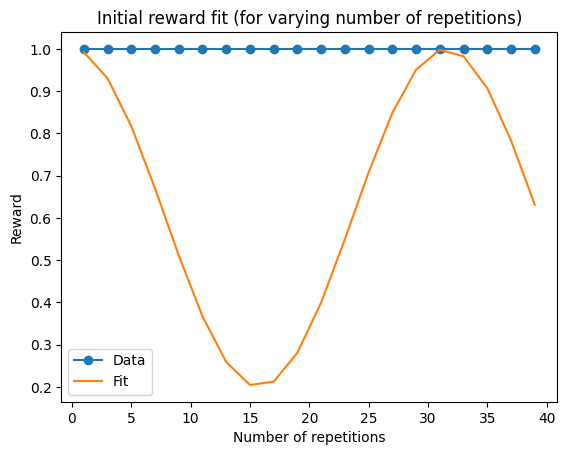

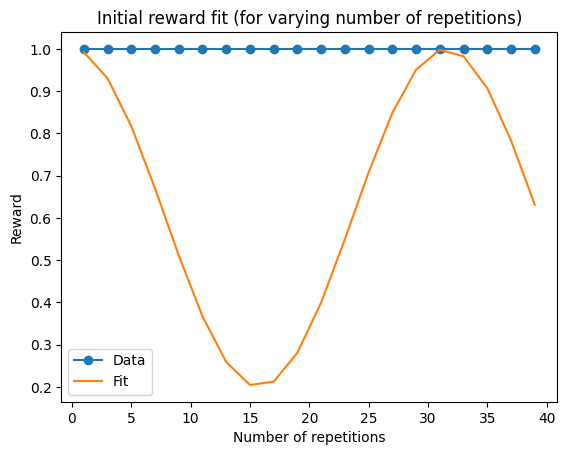

In [32]:
general_env.initial_reward_fit(
    # np.zeros((1, 7)),
    opt_action,
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 40, 2),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="fidelity",
    fit_p0=list(subsystem_spillover_angles)
)

## Running Training for One Spillover Qubit, Fidelity Access, with Random Uniform Sampling

In [45]:
# PPO Details

from ppo_cleanrl import PPO_CleanRL

train_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2, 4],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 400,
    "learning_rate": 3e-3,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 1600,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.0,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(train_env, min_action=-1., max_action=1.)
ppo_agent = PPO_CleanRL(agent_config, rescaled_q_env)

Observation Vals for Agent: [[-1.  -1. ]
 [-1.  -0.5]
 [-1.   0. ]
 [-1.   0.5]
 [-1.   1. ]
 [-0.5 -1. ]
 [-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [-0.5  1. ]
 [ 0.  -1. ]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.   0.5]
 [ 0.   1. ]
 [ 0.5 -1. ]
 [ 0.5 -0.5]
 [ 0.5  0. ]
 [ 0.5  0.5]
 [ 0.5  1. ]
 [ 1.  -1. ]
 [ 1.  -0.5]
 [ 1.   0. ]
 [ 1.   0.5]
 [ 1.   1. ]]
Observation Vals for Env: [[0.         0.        ]
 [0.         0.78539816]
 [0.         1.57079633]
 [0.         2.35619449]
 [0.         3.14159265]
 [0.78539816 0.        ]
 [0.78539816 0.78539816]
 [0.78539816 1.57079633]
 [0.78539816 2.35619449]
 [0.78539816 3.14159265]
 [1.57079633 0.        ]
 [1.57079633 0.78539816]
 [1.57079633 1.57079633]
 [1.57079633 2.35619449]
 [1.57079633 3.14159265]
 [2.35619449 0.        ]
 [2.35619449 0.78539816]
 [2.35619449 1.57079633]
 [2.35619449 2.35619449]
 [2.35619449 3.14159265]
 [3.14159265 0.        ]
 [3.14159265 0.78539816]
 [3.14159265 1.57079633]
 [3.14159265 2.35619449]
 [3.14159265 3.14159

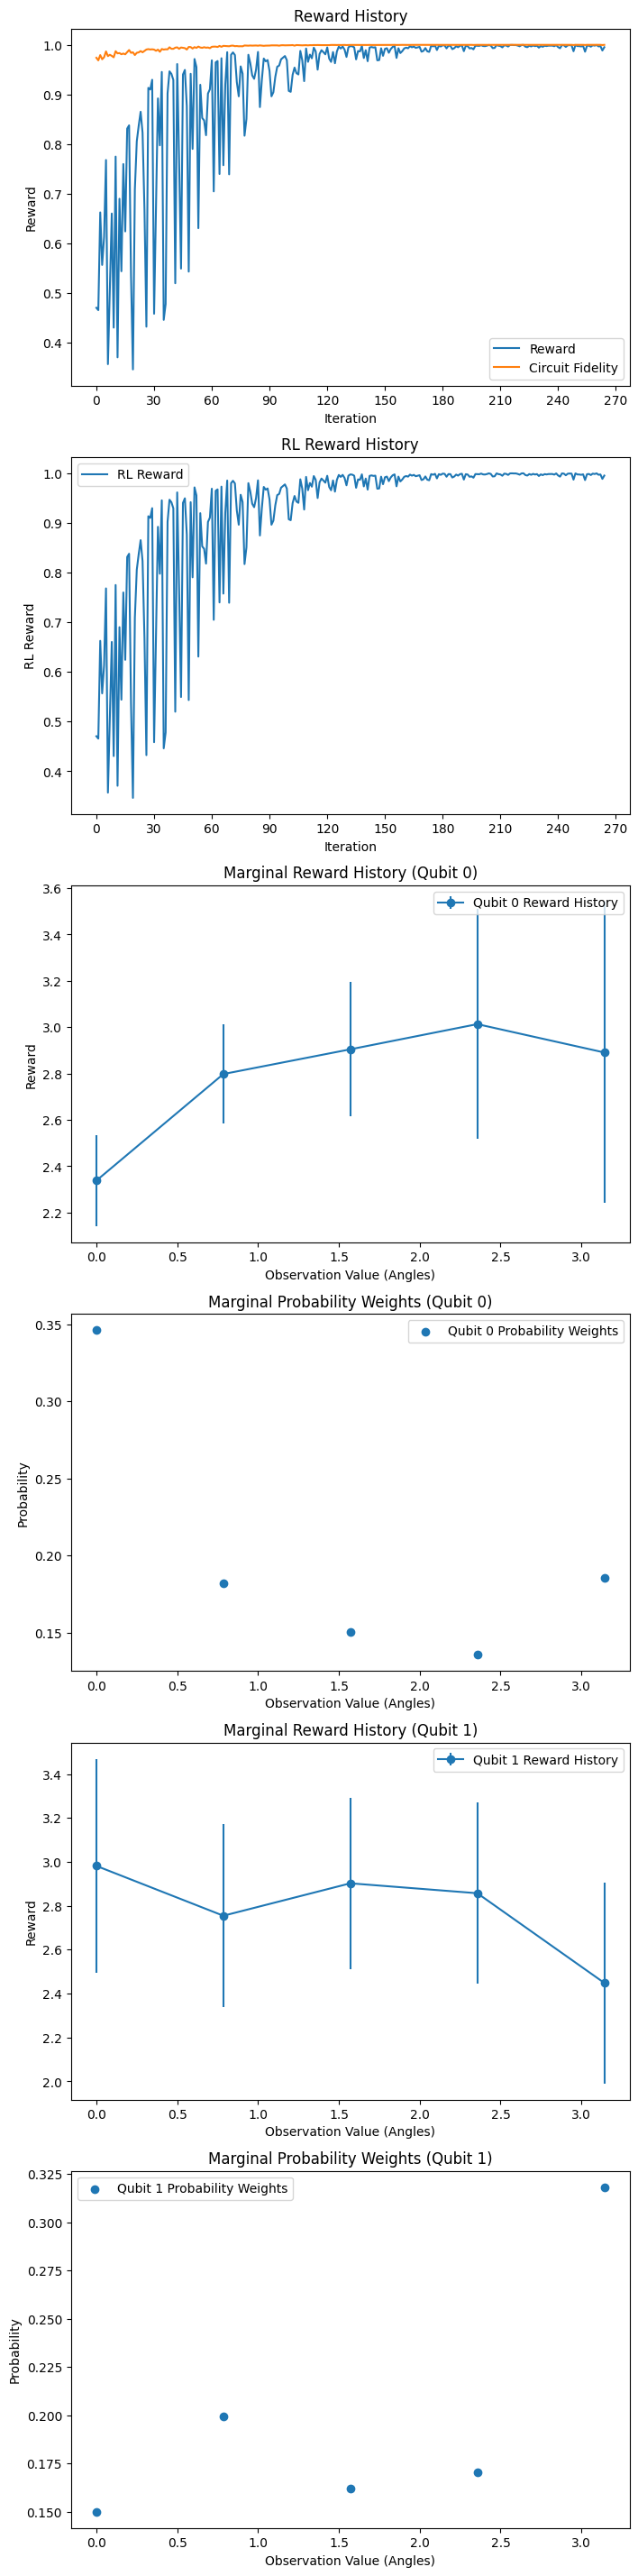

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


batch action shape: (32, 7)
Starting simulation benchmark...


KeyboardInterrupt: 

In [46]:
# from gymnasium.wrappers import ActionWrapper

ppo_agent.env.unwrapped.clear_history()
# ppo_agent.env.clear_history()
ppo_agent.run_training()

## Evaluating Learned Policy from Random Discrete Context Sampling

In [47]:
NUM_EVAL = 25
import torch

action_list = []
obs_list = []
reward_list = []

for n in range(NUM_EVAL):
    obs, _ = ppo_agent.env.reset()
    obs_list.append(obs)
    batch_obs = np.tile(obs, (32, 1))
    with torch.no_grad():
        batch_action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            torch.Tensor(batch_obs)
        )
    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        batch_action.numpy()
    )
    reward_list.append(np.mean(reward))
    mean_action = np.mean(batch_action.numpy(), axis=0)
    action_list.append(mean_action)

Sampled angles:  [0.         0.         0.         0.         1.57079633 0.        ]
Environment Observation: [-1.  0.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999521140868635
Reward (avg): 0.9958353742165889 Std: 0.001233936085391291
obs: [-1.  0.]
reward: [2.46383002 2.26297959 2.186441   2.1421496  2.36401743 2.45166682
 2.32207274 2.36281833 2.48778006 2.39759478 2.4257594  2.61234761
 2.1884771  2.18800026 2.34837213 2.36756853 2.56038222 2.41732767
 2.43880834 2.54133602 2.71727462 2.34522436 2.624547   2.36664624
 2.41955575 2.30878321 2.42456435 2.44619341 2.36953798 2.29214673
 2.53165048 2.40503728]
Sampled angles:  [0.         0.         0.         0.         0.78539816 0.        ]
Environment Observation: [-1.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999096923796458
Reward (avg): 0.9917615296820572 Std: 0.0017609109907508367
obs: [-1.  -0.5]
reward: [2.13538245 2.2117177  2.11626434 1.92680917 1.97166663 2.13679914
 2.06593049 1.97663368 2.13227288 2.09438105 2.11922039 2.18132231
 2.14484804 2.21343285 2.10133047 2.22741411 2.13754457 2.09312389
 2.12957343 1.98269355 2.26713757 2.07138148 2.00070891 2.0231859
 1.96902613 2.04234308 2.06835129 2.17035436 1.90871142 2.01824565
 2.23572147 2.12795601]
Sampled angles:  [0.         0.         0.78539816 0.         1.57079633 0.        ]
Environment Observation: [-0.5  0. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999636560772576
Reward (avg): 0.9980013732792044 Std: 0.0006342359804138028
obs: [-0.5  0. ]
reward: [2.51987807 2.87447658 2.58509922 2.79616429 2.57687607 2.73900506
 2.5797403  2.65853517 2.64916667 2.82575926 2.75110364 2.64316412
 2.76511631 2.82482864 2.48692812 2.68599976 2.86420249 2.71406453
 2.53671525 3.20380125 2.69782963 2.91639766 2.87866353 2.70904892
 3.08234838 2.5053451  2.66252516 2.79230115 2.71596982 2.75236792
 2.58663292 2.61306258]
Sampled angles:  [0.         0.         0.78539816 0.         3.14159265 0.        ]
Environment Observation: [-0.5  1. ]


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999470342992437
Reward (avg): 0.9991686383177588 Std: 0.00038682569472409833
obs: [-0.5  1. ]
reward: [3.04050925 2.95713687 2.91684023 3.13678586 3.03941436 3.32308045
 3.14381892 3.30828356 2.74890971 3.29029844 3.18131193 3.00371776
 2.72971303 3.47064879 3.06382699 3.02215023 3.09500414 3.22371381
 3.66411759 3.02886591 3.34582751 3.35347987 2.90047734 3.40491749
 2.9442823  3.36864004 3.31619402 3.12807158 2.89142222 3.15107254
 3.01580747 2.90529735]
Sampled angles:  [0.         0.         1.57079633 0.         0.78539816 0.        ]
Environment Observation: [ 0.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999567097962476
Reward (avg): 0.998023057421301 Std: 0.000541228140797043
obs: [ 0.  -0.5]
reward: [2.75281895 2.60043847 2.60697606 2.66520493 2.77882026 2.82884499
 2.57809439 2.85386581 2.63792525 2.66742276 2.65000125 2.78600791
 2.67353831 3.0121661  3.09114406 2.5923085  2.76500473 2.71986964
 2.52625676 2.57766288 2.77596932 2.86763329 2.71391319 2.7918338
 2.75611794 2.5745604  2.75116556 2.68510207 2.8028691  2.90087531
 2.59732945 2.53199667]
Sampled angles:  [0.         0.         0.78539816 0.         2.35619449 0.        ]
Environment Observation: [-0.5  0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999686071518716
Reward (avg): 0.9991357721232077 Std: 0.00046954550644068575
obs: [-0.5  0.5]
reward: [3.34959354 3.24634142 3.04574175 3.03950833 2.99029015 2.92001588
 2.84541639 3.21615447 2.71340107 2.7424201  3.75604102 3.57255136
 3.35644423 2.86374205 3.34030904 2.99975857 2.74230297 3.76369414
 2.88788546 2.87045644 3.38622387 2.99231982 3.28473325 3.77305097
 3.07387912 3.05977038 3.21525007 3.06599836 3.19085692 3.01931625
 3.04611589 3.1609809 ]
Sampled angles:  [0.         0.         0.         0.         3.14159265 0.        ]
Environment Observation: [-1.  1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999647418211963
Reward (avg): 0.997573383946954 Std: 0.0015346376104466673
obs: [-1.  1.]
reward: [3.16360099 3.20641471 3.52270048 2.39819964 2.4298558  2.77780016
 2.2315709  2.54181717 2.87411877 2.89066279 2.91582549 3.26713794
 2.99127454 2.99945265 2.21322203 2.44933595 2.50360347 2.49903203
 3.00830836 2.55685453 2.4345066  2.71749793 2.65992747 2.86536511
 2.42550211 2.64708724 2.90812994 2.63334607 2.26444142 2.41108335
 2.68308059 2.77476942]
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1. -1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998465056607508
Reward (avg): 0.9856936180183122 Std: 0.0025742682611444067
obs: [-1. -1.]
reward: [1.98041497 1.86076755 1.88315413 1.72982935 1.84660359 1.81251454
 1.81211267 1.78437946 2.03756126 1.8028579  1.67141578 1.83331253
 1.91286822 1.90449251 1.84717652 1.80467834 1.71637717 1.86649871
 1.75489223 1.92430186 1.868561   1.76143133 1.84926955 1.80877224
 1.92310916 1.88489578 1.83900417 1.95329162 1.90187418 1.83780539
 1.93847874 1.89038376]
Sampled angles:  [0.         0.         2.35619449 0.         0.78539816 0.        ]
Environment Observation: [ 0.5 -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999639645936976
Reward (avg): 0.9990887781109207 Std: 0.00038442536884272365
obs: [ 0.5 -0.5]
reward: [2.85377442 3.11468108 2.82268601 3.09098829 3.33327659 3.19554075
 3.3419753  2.97574868 3.0979571  3.05025299 2.95016098 2.85055919
 3.01331664 2.69189146 3.19494814 3.11189104 3.80720462 3.27517652
 2.943265   3.04346277 2.86903319 2.84390097 2.93487589 3.07674315
 3.25602902 3.16214955 2.89683549 3.15060094 3.25229995 3.0641736
 3.26168148 3.14036928]
Sampled angles:  [0.         0.         3.14159265 0.         0.78539816 0.        ]
Environment Observation: [ 1.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999401681636746
Reward (avg): 0.9997000569366592 Std: 0.0001930654844947088
obs: [ 1.  -0.5]
reward: [3.57553264 3.44813295 3.18052681 3.20547671 3.20337171 3.41648496
 4.21984722 4.24834748 3.79222596 3.526467   4.2997447  3.99386441
 3.38079784 3.47254782 3.67853033 3.25248558 3.86388234 3.66336724
 3.2911647  3.43734272 3.75698853 3.50855402 3.60996905 3.9999038
 3.51355156 4.22231907 4.04311351 3.57908722 3.09586416 3.41096963
 3.62261873 3.64878819]
Sampled angles:  [0.         0.         3.14159265 0.         1.57079633 0.        ]
Environment Observation: [1. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999914113529063
Reward (avg): 0.9989857461499418 Std: 0.00037616586457237065
obs: [1. 0.]
reward: [3.00809326 3.36465318 3.22878042 3.00581013 3.03376348 2.99690366
 2.92329585 3.09428421 3.06227767 2.82395668 2.92039518 3.25696687
 3.04090678 2.95184902 3.00908126 2.92100501 2.62406618 2.98972097
 2.90681454 3.17540764 2.89766944 2.92487055 3.05492246 3.11938737
 3.01214471 3.08057375 2.8966555  3.27858004 2.74002039 3.03482593
 3.10712515 3.16554335]
Sampled angles:  [0.         0.         0.         0.         0.78539816 0.        ]
Environment Observation: [-1.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999119317678365
Reward (avg): 0.991939989996789 Std: 0.0018865519449623338
obs: [-1.  -0.5]
reward: [2.1473858  2.22966102 2.3309454  2.15648298 1.92479125 2.05625667
 2.19586333 2.02875719 2.12925131 2.17882095 2.14305971 2.14400013
 2.17889905 2.10577569 2.18058881 2.06818059 2.03218275 2.00487349
 2.08268645 1.89273421 2.28680912 1.95666087 2.21983847 2.11954785
 1.97369446 2.04194658 2.03633381 2.25623196 2.07055469 2.02326288
 2.12552332 2.05373975]
Sampled angles:  [0.         0.         0.         0.         0.78539816 0.        ]
Environment Observation: [-1.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999906636578617
Reward (avg): 0.9914588672221167 Std: 0.0018980821731054104
obs: [-1.  -0.5]
reward: [2.10989213 2.09061792 1.85872229 2.09391825 2.05525934 2.08814063
 1.96981434 2.00207345 2.04022447 2.19665511 2.09163355 2.04895955
 2.15974197 2.15159418 2.23551988 2.02026161 1.97246602 2.06754862
 2.19222538 2.29882279 2.16717093 2.1726241  1.98952358 2.04517991
 1.97776118 1.91557724 2.16808664 2.12898243 2.02475284 2.15673445
 2.07146398 1.9658035 ]
Sampled angles:  [0.         0.         0.         0.         0.78539816 0.        ]
Environment Observation: [-1.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999141046991737
Reward (avg): 0.9921832055145879 Std: 0.0017053389783098908
obs: [-1.  -0.5]
reward: [2.17843509 2.02539756 2.1473265  2.01864041 2.15536074 2.02174501
 2.11958039 2.13274303 2.25468429 2.08209984 2.13283902 2.20171464
 1.91923447 2.09965738 2.24111019 2.20232225 2.23139179 2.06846612
 2.10483278 2.01131617 2.06223498 2.06370918 2.16355391 2.21120307
 2.15053152 1.92936843 2.19971901 2.17570486 1.96259138 2.12202551
 2.0697715  2.27579911]
Sampled angles:  [0.         0.         2.35619449 0.         3.14159265 0.        ]
Environment Observation: [0.5 1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998543703356237
Reward (avg): 0.9940469186329199 Std: 0.0008989816689136524
obs: [0.5 1. ]
reward: [2.22987024 2.23914147 2.24137301 2.16595265 2.28060013 2.2215069
 2.28568773 2.16074284 2.28670842 2.21963545 2.16771431 2.49673955
 2.26116884 2.18378165 2.13888293 2.31912077 2.33347876 2.1731999
 2.28934017 2.19982921 2.17046652 2.29448417 2.22258884 2.32382922
 2.1479781  2.13968772 2.19445114 2.20900734 2.17206437 2.17508348
 2.22621359 2.21945322]
Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [ 1. -1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999556832207235
Reward (avg): 0.9985249079615987 Std: 0.0005204781698080765
obs: [ 1. -1.]
reward: [2.74545059 2.67145437 2.87734683 2.71994189 3.24554048 2.83336457
 2.99437508 2.85524598 2.95495115 2.71797998 3.00474772 3.01009637
 2.7946879  2.97274139 2.96674701 3.2685966  3.20066711 2.77021218
 2.61167862 2.64962685 2.77379097 2.85376451 2.91760487 2.62829267
 2.88957563 2.72017459 2.96883579 2.9227587  2.63345693 2.69161065
 2.76607357 2.94881877]
Sampled angles:  [0.         0.         0.         0.         3.14159265 0.        ]
Environment Observation: [-1.  1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999683740115061
Reward (avg): 0.997828206131093 Std: 0.0012137381511685371
obs: [-1.  1.]
reward: [2.87421278 2.56683685 2.60046051 3.11113897 2.42114458 2.39037776
 2.49421683 2.48138108 2.91483994 2.25420727 2.89946825 2.79881264
 3.14443378 2.64519179 3.17773971 2.82065148 2.53027255 2.96443034
 2.62834873 3.0583955  2.71140043 3.05521438 2.9639843  2.59076217
 2.36236133 2.95813295 2.67214764 2.97611517 2.77613799 2.66417672
 2.50296654 2.43648391]
Sampled angles:  [0.         0.         3.14159265 0.         3.14159265 0.        ]
Environment Observation: [1. 1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9997250775340576
Reward (avg): 0.9854888912698305 Std: 0.001619527469072179
obs: [1. 1.]
reward: [1.87412574 1.91475369 1.81324234 1.82227273 1.73176589 1.87318379
 1.84732871 1.80766756 1.80937727 1.81221042 1.79106374 1.79358831
 1.90481908 1.85797576 1.88307953 1.85921612 1.96082169 1.83978942
 1.91130952 1.85339201 1.87110347 1.81240685 1.81955287 1.74501077
 1.82572028 1.85647251 1.84378155 1.7946868  1.86746871 1.8777454
 1.85965064 1.77705084]
Sampled angles:  [0.         0.         0.78539816 0.         0.78539816 0.        ]
Environment Observation: [-0.5 -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999385852194316
Reward (avg): 0.9963024534640091 Std: 0.0009077225325777018
obs: [-0.5 -0.5]
reward: [2.37346661 2.34125985 2.40530612 2.37398831 2.50178017 2.35928549
 2.64202162 2.5766209  2.47847191 2.555673   2.54834761 2.36133548
 2.36020286 2.42453709 2.23906582 2.35259652 2.62803231 2.34681728
 2.54016854 2.36404255 2.57359222 2.40778378 2.67933462 2.53448873
 2.57065879 2.34277562 2.45730231 2.34978779 2.5491653  2.40065227
 2.34067204 2.29274206]
Sampled angles:  [0.         0.         0.78539816 0.         0.78539816 0.        ]
Environment Observation: [-0.5 -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999467485304325
Reward (avg): 0.9964761467621011 Std: 0.001178146624901973
obs: [-0.5 -0.5]
reward: [2.48687387 2.5422523  2.4118845  2.4384487  2.77303852 2.59277801
 2.54251201 2.43477112 2.06456999 2.51115326 2.37582258 2.53177161
 2.45856862 2.40773558 2.55025003 2.44529531 2.4930942  2.40233098
 2.3512417  2.47176601 2.25851929 2.49965348 2.54397775 2.51183134
 2.34813666 2.69767041 2.55484469 2.35658919 2.48830563 2.53282291
 2.46770895 2.55102117]
Sampled angles:  [0.         0.         0.78539816 0.         0.78539816 0.        ]
Environment Observation: [-0.5 -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999484702662729
Reward (avg): 0.9964322129779319 Std: 0.000859267583479084
obs: [-0.5 -0.5]
reward: [2.35595635 2.41447364 2.52511644 2.4677653  2.30395028 2.44454687
 2.26713388 2.39033812 2.44930344 2.61696905 2.54806928 2.41659871
 2.56575128 2.26154412 2.63186829 2.4353568  2.60921481 2.4909292
 2.42623739 2.42847982 2.61429184 2.34006805 2.3309262  2.42225549
 2.57538384 2.51996939 2.56287161 2.54167703 2.46479457 2.55137772
 2.40859398 2.33609493]
Sampled angles:  [0.         0.         0.         0.         1.57079633 0.        ]
Environment Observation: [-1.  0.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999472250927658
Reward (avg): 0.9955719771628406 Std: 0.001261957342662241
obs: [-1.  0.]
reward: [2.22559428 2.63520401 2.43406497 2.32039137 2.38103132 2.21579861
 2.448495   2.31192978 2.29723523 2.29967679 2.56594006 2.22186049
 2.43117164 2.39536134 2.2202545  2.38005006 2.29957351 2.40489634
 2.41576735 2.49142534 2.59269137 2.30402813 2.36323287 2.30718164
 2.55645305 2.2030416  2.21545977 2.57629791 2.14176776 2.30126027
 2.36565226 2.60400856]
Sampled angles:  [0.         0.         2.35619449 0.         3.14159265 0.        ]
Environment Observation: [0.5 1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998421798247223
Reward (avg): 0.9940676115113829 Std: 0.0008716758660906981
obs: [0.5 1. ]
reward: [2.16577228 2.30075183 2.16212884 2.28700328 2.22598191 2.28346862
 2.16048012 2.41066166 2.19847364 2.26831152 2.29179848 2.17118188
 2.27510298 2.22249062 2.34366658 2.17378915 2.14542483 2.27449419
 2.24776705 2.12370964 2.29921726 2.2722155  2.18488542 2.35373391
 2.23898652 2.18213572 2.20247348 2.18621953 2.17390632 2.16178409
 2.21286474 2.21514102]
Sampled angles:  [0.         0.         1.57079633 0.         1.57079633 0.        ]
Environment Observation: [0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999629029076121
Reward (avg): 0.9990674910201467 Std: 0.00039929447141119357
obs: [0. 0.]
reward: [3.08589289 2.9316711  3.02865275 2.90486543 3.23972253 3.41999324
 2.9847285  2.98526033 3.10095032 3.77999213 2.72630821 2.92131334
 3.21927023 3.19429627 2.70752382 3.32444408 3.13604264 2.91618684
 2.8949872  3.06074301 3.09697701 3.19114544 2.98664569 3.45106603
 3.07378459 2.80303313 3.16473829 2.90489329 3.10176118 3.05763343
 2.89427827 3.1402509 ]
Sampled angles:  [0.         0.         0.         0.         0.78539816 0.        ]
Environment Observation: [-1.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999097017247083
Reward (avg): 0.9917962258298356 Std: 0.0015257811840166543
obs: [-1.  -0.5]
reward: [2.19000506 2.13283087 2.05488328 1.98234149 2.17796134 2.17963279
 2.15658219 2.03854546 2.04085482 2.12308288 2.02075969 1.95166812
 2.04250051 2.06518798 2.05741028 2.1827341  2.0206355  2.12952457
 2.20969056 2.11425461 2.09399302 2.19389889 2.13886701 2.18000027
 1.98411048 2.11062561 2.24238409 2.06384729 2.06496877 2.06164746
 2.07002437 1.90881216]


/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_3030/4258992135.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


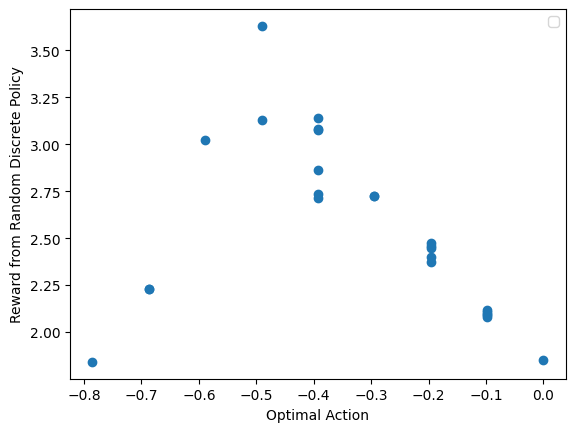

In [48]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[2, 4], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.2

plt.scatter(optimal_action, reward_list)
plt.xlabel('Optimal Action')
plt.ylabel('Reward from Random Discrete Policy')
plt.legend()
plt.show()

In [49]:
df_hist = ppo_agent.env.unwrapped.discrete_reward_history

print(df_hist.shape)

(3, 25)


In [50]:
print(df_hist)

[[1.85134644 2.0932583  2.37271241 2.67064734 2.7327014  2.84567671
  2.45993462 2.72478492 3.14158013 3.12855117 2.32764956 2.72230432
  3.07590788 2.67492355 2.44603538 3.66684512 3.08335782 3.50428255
  3.0335961  2.23175071 2.86188157 3.63005839 3.02032346 3.81611874
  1.84098856]
 [2.3767498  2.11672219 2.39940285 2.54396884 2.71454768 3.08569714
  2.47178876 3.18025666 3.17374497 2.70503407 3.30503033 2.81593208
  2.82297819 2.83273597 3.4795073  3.53163322 2.62977615 2.78647682
  3.21887076 2.23093071 3.78487854 3.5880949  3.5142169  3.53633717
  1.94453754]
 [2.41364799 2.07899226 2.48458576 2.27917943 2.44099754 2.86699196
  2.44599924 2.7764711  2.60267892 2.64306146 2.78282606 3.16918978
  3.15734441 2.90891492 2.93980178 3.44821552 3.48130585 3.4564601
  2.45379408 2.38408506 3.26871543 2.70175844 2.83215772 2.47795421
  1.8619373 ]]


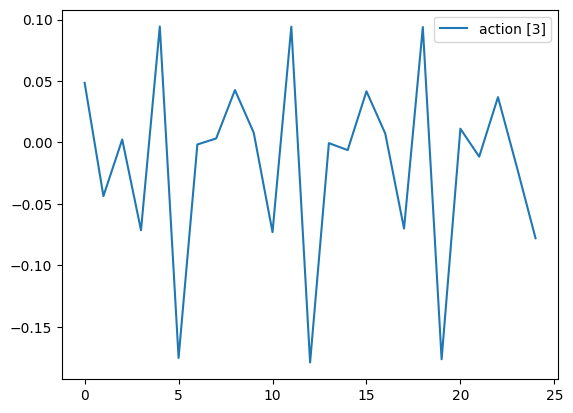

In [51]:
action_arr = np.array(action_list)
action_arr = action_arr.reshape(7, -1)

for i in range(len(action_arr)):
    if i == 3:
        plt.plot(action_arr[i], label=f'action [{i}]')
plt.legend()
plt.show()

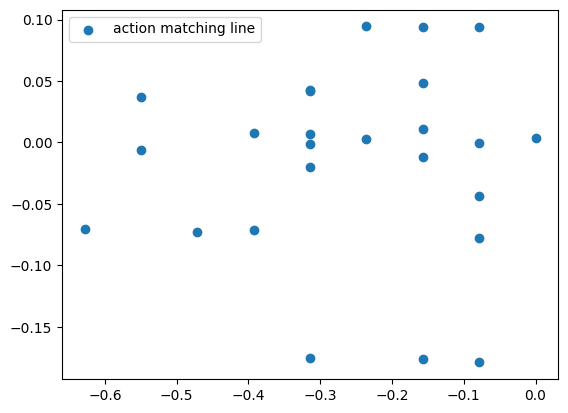

In [52]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[2, 4], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.25

action_relevant = action_arr[3]

plt.scatter(optimal_action, np.clip(action_relevant, a_min=-1., a_max=1.), label='action matching line')
plt.legend()
plt.show()

In [53]:
single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=4,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = GeneralAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2, 4],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [[-1.  -1. ]
 [-1.  -0.5]
 [-1.   0. ]
 [-1.   0.5]
 [-1.   1. ]
 [-0.5 -1. ]
 [-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [-0.5  1. ]
 [ 0.  -1. ]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.   0.5]
 [ 0.   1. ]
 [ 0.5 -1. ]
 [ 0.5 -0.5]
 [ 0.5  0. ]
 [ 0.5  0.5]
 [ 0.5  1. ]
 [ 1.  -1. ]
 [ 1.  -0.5]
 [ 1.   0. ]
 [ 1.   0.5]
 [ 1.   1. ]]
Observation Vals for Env: [[0.         0.        ]
 [0.         0.78539816]
 [0.         1.57079633]
 [0.         2.35619449]
 [0.         3.14159265]
 [0.78539816 0.        ]
 [0.78539816 0.78539816]
 [0.78539816 1.57079633]
 [0.78539816 2.35619449]
 [0.78539816 3.14159265]
 [1.57079633 0.        ]
 [1.57079633 0.78539816]
 [1.57079633 1.57079633]
 [1.57079633 2.35619449]
 [1.57079633 3.14159265]
 [2.35619449 0.        ]
 [2.35619449 0.78539816]
 [2.35619449 1.57079633]
 [2.35619449 2.35619449]
 [2.35619449 3.14159265]
 [3.14159265 0.        ]
 [3.14159265 0.78539816]
 [3.14159265 1.57079633]
 [3.14159265 2.35619449]
 [3.14159265 3.14159

In [56]:
# Visualizing Policy wrt actions

import torch

full_actions = []
actions = []
std_actions = []

for sample_obs in ppo_agent.env.unwrapped.discrete_obs_vals_raw:
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.2
    full_actions.append(cpu_action)
    actions.append(np.mean(cpu_action, axis=0))
    std_actions.append(np.std(cpu_action, axis=0))

In [57]:
print(std_actions)

[array([0.00213739, 0.00361427, 0.00342711, 0.00144919, 0.00573086,
       0.00432513, 0.00302216], dtype=float32), array([0.00180848, 0.00292298, 0.00389777, 0.00169242, 0.00401607,
       0.00530279, 0.00372977], dtype=float32), array([0.00198177, 0.00404829, 0.00387106, 0.00148603, 0.00415028,
       0.00457357, 0.00319733], dtype=float32), array([0.0017651 , 0.00389798, 0.00304049, 0.00168355, 0.00516243,
       0.00635029, 0.00374263], dtype=float32), array([0.00194783, 0.00368856, 0.00376492, 0.00172776, 0.00426923,
       0.00527978, 0.00357433], dtype=float32), array([0.00264546, 0.00294671, 0.00326669, 0.00162953, 0.00525587,
       0.00551106, 0.00309398], dtype=float32), array([0.0022407 , 0.00394251, 0.00383336, 0.00140097, 0.00497636,
       0.00616778, 0.00319084], dtype=float32), array([0.00209037, 0.00334707, 0.00293952, 0.00156898, 0.00523797,
       0.00432119, 0.00289729], dtype=float32), array([0.00235305, 0.00235867, 0.00326101, 0.00135986, 0.00590368,
       0.005

In [59]:
actions = np.array(actions)

o_vals = ppo_agent.env.unwrapped.discrete_obs_vals_angles
o_vals

array([[0.        , 0.        ],
       [0.        , 0.78539816],
       [0.        , 1.57079633],
       [0.        , 2.35619449],
       [0.        , 3.14159265],
       [0.78539816, 0.        ],
       [0.78539816, 0.78539816],
       [0.78539816, 1.57079633],
       [0.78539816, 2.35619449],
       [0.78539816, 3.14159265],
       [1.57079633, 0.        ],
       [1.57079633, 0.78539816],
       [1.57079633, 1.57079633],
       [1.57079633, 2.35619449],
       [1.57079633, 3.14159265],
       [2.35619449, 0.        ],
       [2.35619449, 0.78539816],
       [2.35619449, 1.57079633],
       [2.35619449, 2.35619449],
       [2.35619449, 3.14159265],
       [3.14159265, 0.        ],
       [3.14159265, 0.78539816],
       [3.14159265, 1.57079633],
       [3.14159265, 2.35619449],
       [3.14159265, 3.14159265]])

In [62]:
ana_sum = -np.sum(o_vals, axis=1) * 0.025
ana_sum

array([-0.        , -0.01963495, -0.03926991, -0.05890486, -0.07853982,
       -0.01963495, -0.03926991, -0.05890486, -0.07853982, -0.09817477,
       -0.03926991, -0.05890486, -0.07853982, -0.09817477, -0.11780972,
       -0.05890486, -0.07853982, -0.09817477, -0.11780972, -0.13744468,
       -0.07853982, -0.09817477, -0.11780972, -0.13744468, -0.15707963])

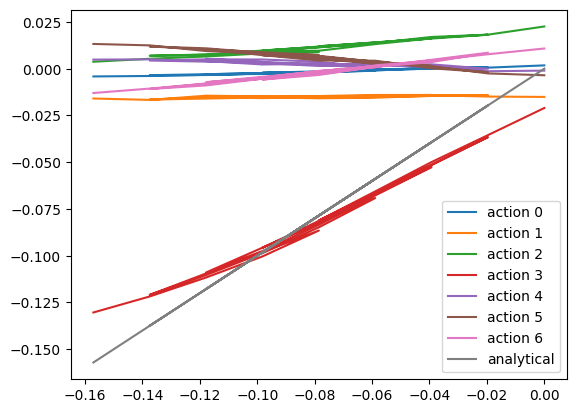

In [64]:
for i in range(len(actions[0])):
    plt.plot(ana_sum, actions[:,i], label=f'action {i}')
# plt.plot(o_vals, (actions[:,1] - actions[:,2]) * np.pi, label=f'sum')
plt.plot(ana_sum, ana_sum, label=f'analytical')
plt.legend()
plt.show()

In [55]:
ppo_agent.env.unwrapped.discrete_obs_vals_raw

array([[-1. , -1. ],
       [-1. , -0.5],
       [-1. ,  0. ],
       [-1. ,  0.5],
       [-1. ,  1. ],
       [-0.5, -1. ],
       [-0.5, -0.5],
       [-0.5,  0. ],
       [-0.5,  0.5],
       [-0.5,  1. ],
       [ 0. , -1. ],
       [ 0. , -0.5],
       [ 0. ,  0. ],
       [ 0. ,  0.5],
       [ 0. ,  1. ],
       [ 0.5, -1. ],
       [ 0.5, -0.5],
       [ 0.5,  0. ],
       [ 0.5,  0.5],
       [ 0.5,  1. ],
       [ 1. , -1. ],
       [ 1. , -0.5],
       [ 1. ,  0. ],
       [ 1. ,  0.5],
       [ 1. ,  1. ]])

In [42]:
obs, _ = ppo_agent.env.reset()
print(obs)

[-0.5 -0.5 -1.  -1.   0. ]
Sampled angles:  [0.78539816 0.78539816 0.         0.         0.         1.57079633]
Environment Observation: [-0.5 -0.5 -1.  -1.   0. ]
[-0.5 -0.5 -1.  -1.   0. ]


In [43]:
print(obs)

[-0.5 -0.5 -1.  -1.   0. ]


## Testing New PPO Algo

In [44]:
import uuid
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from gymnasium.spaces import Box
from typing import Dict, Optional, Any
import collections

# Adapted from CleanRL ppo_continuous_action.py
from rl_qoc.environment.base_q_env import BaseQuantumEnvironment

def process_action(self, probs: Normal):
    """
    Decide how actions should be processed before being sent to environment.
    For certain environments such as QUA, policy parameters should be streamed to the environment directly
    and actions are sampled within the environment (in real time).
    """
    action = probs.sample()
    logprob = probs.log_prob(action).sum(1)
    mean_action = probs.mean
    std_action = probs.stddev

    if isinstance(self.env, ActionWrapper):
        self.unwrapped_env.mean_action = self.env.action(mean_action[0].cpu().numpy())
    else:
        self.unwrapped_env.mean_action = mean_action[0].cpu().numpy()

    self.unwrapped_env.std_action = std_action[0].cpu().numpy()
    return action, logprob

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

def plot_curves(env: BaseQuantumEnvironment):
    """
    Plots the reward history, fidelity history, and (for moving_discrete) marginal reward and probability distributions for each qubit.
    """
    fidelity_range = [i * env.benchmark_cycle for i in range(len(env.fidelity_history))]
    num_qubits = len(env.unwrapped.applied_qubits)  # Number of qubits
    # Number of subplots: 2 for reward/fidelity, plus 2 per qubit for moving_discrete
    num_plots = 2 + (2 * num_qubits if env.unwrapped.circuit_param_distribution == "moving_discrete" else 0)
    fig, ax = plt.subplots(num_plots, 1, figsize=(8.0, 6.0 * num_plots), squeeze=False)
    ax = ax.flatten()

    # Plot average reward and fidelity history
    ax[0].plot(np.mean(env.reward_history, axis=1), label="Reward")
    ax[0].plot(
        fidelity_range,
        env.fidelity_history,
        label="Circuit Fidelity",
    )
    ax[0].set_title("Reward History")
    ax[0].legend()
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Reward")
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot RL reward history
    ax[1].plot(np.mean(env.reward_history, axis=1), label="RL Reward")
    ax[1].set_title("RL Reward History")
    ax[1].legend()
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("RL Reward")
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    if env.unwrapped.circuit_param_distribution == "moving_discrete":
        # Single-qubit discrete values and their corresponding angles
        single_qubit_vals = env.unwrapped.single_qubit_discrete_obs_vals_raw
        angles = env.unwrapped.obs_raw_to_angles(single_qubit_vals)
        num_vals = len(single_qubit_vals)

        for qubit_idx in range(num_qubits):
            # Compute marginal reward distribution for this qubit
            marginal_rewards = np.zeros(num_vals)
            marginal_std = np.zeros(num_vals)
            for i, val in enumerate(single_qubit_vals):
                # Find indices where this qubit has the given value
                mask = np.isclose(env.unwrapped.discrete_obs_vals_raw[:, qubit_idx], val, rtol=1e-5, atol=1e-8)
                marginal_rewards[i] = np.mean(env.unwrapped.discrete_reward_history[:, mask]) if np.any(mask) else 0
                marginal_std[i] = np.std(env.unwrapped.discrete_reward_history[:, mask]) if np.any(mask) else 0

            # Plot marginal reward history with error bars
            ax[2 + qubit_idx * 2].errorbar(
                angles,
                marginal_rewards,
                yerr=marginal_std,
                fmt='-o',
                label=f"Qubit {qubit_idx} Reward History",
            )
            ax[2 + qubit_idx * 2].set_title(f"Marginal Reward History (Qubit {qubit_idx})")
            ax[2 + qubit_idx * 2].legend()
            ax[2 + qubit_idx * 2].set_xlabel("Observation Value (Angles)")
            ax[2 + qubit_idx * 2].set_ylabel("Reward")

            # Compute marginal probability distribution
            marginal_probs = np.zeros(num_vals)
            for i, val in enumerate(single_qubit_vals):
                mask = np.isclose(env.unwrapped.discrete_obs_vals_raw[:, qubit_idx], val, rtol=1e-5, atol=1e-8)
                marginal_probs[i] = np.sum(env.unwrapped.prob_weights[mask]) if np.any(mask) else 0

            # Plot marginal probability weights
            ax[3 + qubit_idx * 2].scatter(
                angles,
                marginal_probs,
                label=f"Qubit {qubit_idx} Probability Weights",
            )
            ax[3 + qubit_idx * 2].set_title(f"Marginal Probability Weights (Qubit {qubit_idx})")
            ax[3 + qubit_idx * 2].legend()
            ax[3 + qubit_idx * 2].set_xlabel("Observation Value (Angles)")
            ax[3 + qubit_idx * 2].set_ylabel("Probability")
    
    plt.show()

class Agent(nn.Module):
    def __init__(
        self,
        env,
        use_combined_networks,
        activation_function_str,
        layer_size,
        robust_ppo,
    ):
        super().__init__()
        self.use_combined_networks = use_combined_networks
        self.robust_ppo = robust_ppo
        if activation_function_str == "tanh":
            self.activation_fn = nn.Tanh
        elif activation_function_str == "relu":
            self.activation_fn = nn.ReLU
        elif activation_function_str == "gelu":
            self.activation_fn = nn.GELU
        elif activation_function_str == "leaky_relu":
            self.activation_fn = nn.LeakyReLU
        elif activation_function_str == "elu":
            self.activation_fn = nn.ELU

        if not self.use_combined_networks:
            self.critic = nn.Sequential(
                layer_init(
                    nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)
                ),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, 1), std=1.0),
            )
            self.actor_mean = nn.Sequential(
                layer_init(
                    nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)
                ),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(
                    nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01
                ),
            )
            self.actor_logstd = nn.Parameter(
                torch.zeros(1, np.prod(env.action_space.shape))
            )

        if self.use_combined_networks:
            self.main_network = nn.Sequential(
                layer_init(
                    nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)
                ),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
            )
            self.actor_mean = nn.Sequential(
                self.main_network,
                layer_init(
                    nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01
                ),
            )
            self.critic = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, 1), std=1.0),
            )
            self.actor_logstd = nn.Parameter(
                torch.zeros(1, np.prod(env.action_space.shape))
            )

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return (
            action,
            probs.log_prob(action).sum(1),
            probs.entropy().sum(1),
            self.critic(x),
        )

class PPO_ContextBuffer:
    def __init__(
        self,
        agent_config: Dict,
        env: BaseQuantumEnvironment,
        chkpt_dir: Optional[str] = "tmp/ppo",
        chkpt_dir_critic: Optional[str] = "tmp/critic_ppo",
        num_warmup_updates: int = 100,
        context_buffer_size: int = 1000,
        noise_scale: float = 0.1,
    ):
        # General Run Params
        self.agent_config = agent_config
        self.exp_name = self.agent_config["exp_name"]
        self.seed = self.agent_config["seed"]
        self.torch_deterministic = self.agent_config["torch_deterministic"]
        self.cuda = self.agent_config["cuda"]
        self.track = self.agent_config["track"]
        self.wandb_project_name = self.agent_config["wandb_project_name"]
        self.wandb_entity = self.agent_config["wandb_entity"]
        self.save_model = self.agent_config["save_model"]
        self.plot_real_time = self.agent_config["plot_real_time"]
        self.num_prints = self.agent_config["num_prints"]

        # PPO Specific Params
        self.num_updates = self.agent_config["total_updates"]
        self.learning_rate = self.agent_config["learning_rate"]
        self.num_envs = self.agent_config["num_envs"]
        self.num_steps = self.agent_config["num_steps"]
        self.anneal_lr = self.agent_config["anneal_lr"]
        self.anneal_num_updates = self.agent_config["anneal_num_updates"]
        self.exp_anneal_lr = self.agent_config["exp_anneal_lr"]
        self.exp_update_time = self.agent_config["exp_update_time"]
        self.plateau_lr = self.agent_config["plateau_lr"]
        self.gamma = self.agent_config["gamma"]
        self.gae_lambda = self.agent_config["gae_lambda"]
        self.num_minibatches = self.agent_config["num_minibatches"]
        self.update_epochs = self.agent_config["update_epochs"]
        self.norm_adv = self.agent_config["norm_adv"]
        self.activation_function_str = self.agent_config["activation_function_str"]
        self.use_combined_networks = self.agent_config["use_combined_networks"]
        self.layer_size = self.agent_config["layer_size"]
        self.clip_coef = self.agent_config["clip_coef"]
        self.clip_vloss = self.agent_config["clip_vloss"]
        self.ent_coef = self.agent_config["ent_coef"]
        self.vf_coef = self.agent_config["vf_coef"]
        self.max_grad_norm = self.agent_config["max_grad_norm"]
        self.target_kl = self.agent_config["target_kl"]
        self.robust_ppo = self.agent_config["robust_ppo"]

        # Context Buffer Params
        self.num_warmup_updates = num_warmup_updates
        self.context_buffer_size = context_buffer_size
        self.noise_scale = noise_scale
        self.context_buffer = collections.deque()
        self.context_rewards = []
        self.context_history = []  # List to store (update_number, context) tuples

        self.batch_size = int(self.num_envs * self.num_steps)
        self.minibatch_size = int(self.batch_size // self.num_minibatches)

        assert (
            self.anneal_lr + self.exp_anneal_lr
        ), "Learning Rate Combination doesn't work"

        self.run_name = (
            f"PPO_ContextBuffer__{self.exp_name}__{self.seed}__{int(time.time())}"
        )

        if self.track:
            import wandb

            wandb.init(
                project=self.wandb_project_name,
                entity=self.wandb_entity,
                sync_tensorboard=True,
                config=self.agent_config,
                name=self.run_name,
                monitor_gym=True,
                save_code=True,
            )
        self.writer = SummaryWriter(f"runs/{self.run_name}")
        self.writer.add_text(
            "hyperparameters",
            "|param|value|\n|-|-|\n%s"
            % (
                "\n".join(
                    [f"|{key}|{value}|" for key, value in self.agent_config.items()]
                )
            ),
        )

        # Seeding
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.backends.cudnn.deterministic = self.torch_deterministic

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() and self.cuda else "cpu"
        )
        self.env = env

        self.agent = Agent(
            self.env,
            self.use_combined_networks,
            self.activation_function_str,
            self.layer_size,
            self.robust_ppo,
        ).to(self.device)
        self.optimizer = optim.Adam(
            self.agent.parameters(), lr=self.learning_rate, eps=1e-5
        )

    def plot_context_history(self):
        updates, contexts = zip(*self.context_history)
        contexts = np.array(contexts)
        plt.figure(figsize=(10, 6))
        for i in range(contexts.shape[1]):
            plt.plot(updates, contexts[:, i], label=f"Context Dim {i}")
        plt.xlabel("Update")
        plt.ylabel("Context Value")
        plt.title("Context Sampling History")
        plt.legend()
        plt.show()

    def add_to_context_buffer(self, context, reward):
        """Add context-reward pair to buffer and maintain size"""
        print(f"Before append: context_buffer={len(self.context_buffer)}, context_rewards={len(self.context_rewards)}")
        self.context_buffer.append(context)
        self.context_rewards.append(reward)
        if len(self.context_buffer) > self.context_buffer_size:
            self.context_buffer.popleft()
            print(f"context rewards before: {self.context_rewards}")
            self.context_rewards.pop(0)
            print(f"context rewards after: {self.context_rewards}")
        print(f"After append: context_buffer={len(self.context_buffer)}, context_rewards={len(self.context_rewards)}")
        assert len(self.context_buffer) == len(self.context_rewards), \
            f"Buffer length mismatch: context_buffer={len(self.context_buffer)}, context_rewards={len(self.context_rewards)}"

    def sample_context(self, warmup=False):
        """Sample context from buffer or randomly during warmup"""
        if warmup or len(self.context_buffer) == 0:
            return np.random.uniform(
                self.env.observation_space.low,
                self.env.observation_space.high,
                self.env.observation_space.shape,
            )
        else:
            # Create probability distribution based on inverse rewards
            rewards = np.array(self.context_rewards)
            # Avoid division by zero and handle negative rewards
            rewards = np.clip(rewards, a_min=1e-6, a_max=None)
            prob_weights = 1.0 / rewards
            prob_weights = prob_weights / np.sum(prob_weights)

            # Sample context from buffer
            idx = np.random.choice(len(self.context_buffer), p=prob_weights)
            context = self.context_buffer[idx]

            # Add noise to sampled context
            noise = np.random.normal(0, self.noise_scale, context.shape)
            noisy_context = context + noise
            # Clip to observation space bounds
            noisy_context = np.clip(
                noisy_context,
                self.env.observation_space.low,
                self.env.observation_space.high,
            )

            return noisy_context

    def run_training(self):
        # Storage setup
        self.obs = torch.zeros(
            (self.num_steps, self.num_envs) + self.env.observation_space.shape
        ).to(self.device)
        self.actions = torch.zeros(
            (self.num_steps, self.num_envs) + self.env.action_space.shape
        ).to(self.device)
        self.logprobs = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.rewards = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.dones = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.values = torch.zeros((self.num_steps, self.num_envs)).to(self.device)

        # Start training
        global_step = 0
        start_time = time.time()

        for update in range(1, self.num_updates + 1):
            # Determine if in warmup phase
            is_warmup = update <= self.num_warmup_updates

            # Sample new context
            context = self.sample_context(warmup=is_warmup)
            # Store context in history
            self.context_history.append((update, context.copy()))

            # Reset environment with sampled context
            next_obs, _ = self.env.unwrapped.reset(debug_obs=context)
            next_obs = np.tile(next_obs, (self.num_envs, 1))
            next_obs = torch.Tensor(next_obs).to(self.device)
            next_done = torch.zeros(self.num_envs).to(self.device)

            # Annealing the Learning Rate
            if self.anneal_lr or self.exp_anneal_lr:
                if self.anneal_lr:
                    frac = 1.0 - (update - 1.0) / self.anneal_num_updates
                    lrnow = (
                        np.clip(frac, a_min=0.0, a_max=None) * self.learning_rate
                        + self.plateau_lr
                    )
                    self.optimizer.param_groups[0]["lr"] = lrnow
                if self.exp_anneal_lr:
                    lrnow = (
                        self.learning_rate * np.exp(-update / self.exp_update_time)
                        + self.plateau_lr
                    )
                    self.optimizer.param_groups[0]["lr"] = lrnow

            for step in range(0, self.num_steps):
                global_step += self.num_envs
                self.obs[step] = next_obs
                self.dones[step] = next_done

                # Action logic
                with torch.no_grad():
                    action, logprob, _, value = self.agent.get_action_and_value(
                        next_obs
                    )
                    self.values[step] = value.flatten()
                self.actions[step] = action
                self.logprobs[step] = logprob

                # Execute step
                cpu_action = action.cpu().numpy()
                mean_action = np.mean(cpu_action, axis=0)
                self.env.unwrapped.mean_action = self.env.action(mean_action)

                next_obs, reward, terminations, truncations, infos = self.env.step(
                    cpu_action
                )
                print(f"Mean Action: {np.mean(cpu_action, axis=0)}")

                # Add to context buffer
                mean_reward = np.mean(reward)
                self.add_to_context_buffer(context, mean_reward)

                next_obs = np.tile(next_obs, (self.num_envs, 1))
                next_done = np.logical_or(terminations, truncations)
                if next_done.any():
                    context = self.sample_context(warmup=is_warmup)
                    self.context_history.append((update, context.copy()))
                    next_obs, _ = self.env.unwrapped.reset(debug_obs=context)
                    next_obs = np.tile(next_obs, (self.num_envs, 1))

                self.rewards[step] = torch.tensor(reward).to(self.device).view(-1)
                next_obs, next_done = torch.Tensor(next_obs).to(
                    self.device
                ), torch.Tensor(next_done).to(self.device)

                if "final_info" in infos:
                    for info in infos["final_info"]:
                        if info and "episode" in info:
                            print(
                                f"global_step={global_step}, episodic_return={info['episode']['r']}"
                            )
                            self.writer.add_scalar(
                                "charts/episodic_return",
                                info["episode"]["r"],
                                global_step,
                            )
                            self.writer.add_scalar(
                                "charts/episodic_length",
                                info["episode"]["l"],
                                global_step,
                            )

            # Bootstrap value
            with torch.no_grad():
                next_value = self.agent.get_value(next_obs).reshape(1, -1)
                advantages = torch.zeros_like(self.rewards).to(self.device)
                lastgaelam = 0
                for t in reversed(range(self.num_steps)):
                    if t == self.num_steps - 1:
                        nextnonterminal = 1.0 - next_done
                        nextvalues = next_value
                    else:
                        nextnonterminal = 1.0 - self.dones[t + 1]
                        nextvalues = self.values[t + 1]
                    delta = (
                        self.rewards[t]
                        + self.gamma * nextvalues * nextnonterminal
                        - self.values[t]
                    )
                    advantages[t] = lastgaelam = (
                        delta
                        + self.gamma * self.gae_lambda * nextnonterminal * lastgaelam
                    )
                returns = advantages + self.values

            # Flatten batch
            b_obs = self.obs.reshape((-1,) + self.env.observation_space.shape)
            b_logprobs = self.logprobs.reshape(-1)
            b_actions = self.actions.reshape((-1,) + self.env.action_space.shape)
            b_advantages = advantages.reshape(-1)
            b_returns = returns.reshape(-1)
            b_values = self.values.reshape(-1)

            # Optimize policy and value network
            b_inds = np.arange(self.batch_size)
            clipfracs = []
            for epoch in range(self.update_epochs):
                np.random.shuffle(b_inds)
                for start in range(0, self.batch_size, self.minibatch_size):
                    end = start + self.minibatch_size
                    mb_inds = b_inds[start:end]

                    _, newlogprob, entropy, newvalue = self.agent.get_action_and_value(
                        b_obs[mb_inds], b_actions[mb_inds]
                    )
                    logratio = newlogprob - b_logprobs[mb_inds]
                    ratio = logratio.exp()

                    with torch.no_grad():
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clipfracs += [
                            ((ratio - 1.0).abs() > self.clip_coef).float().mean().item()
                        ]

                    mb_advantages = b_advantages[mb_inds]
                    if self.norm_adv:
                        mb_advantages = (mb_advantages - mb_advantages.mean()) / (
                            mb_advantages.std() + 1e-8
                        )

                    # Policy loss
                    pg_loss1 = -mb_advantages * ratio
                    pg_loss2 = -mb_advantages * torch.clamp(
                        ratio, 1 - self.clip_coef, 1 + self.clip_coef
                    )
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    # Value loss
                    newvalue = newvalue.view(-1)
                    if self.clip_vloss:
                        v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                        v_clipped = b_values[mb_inds] + torch.clamp(
                            newvalue - b_values[mb_inds],
                            -self.clip_coef,
                            self.clip_coef,
                        )
                        v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                        v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                        v_loss = 0.5 * v_loss_max.mean()
                    else:
                        v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

                    entropy_loss = entropy.mean()
                    loss = (
                        pg_loss - self.ent_coef * entropy_loss + v_loss * self.vf_coef
                    )

                    self.optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(
                        self.agent.parameters(), self.max_grad_norm
                    )
                    self.optimizer.step()

                if self.target_kl is not None and approx_kl > self.target_kl:
                    break

            y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
            var_y = np.var(y_true)
            explained_var = (
                np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y
            )

            # Log metrics
            self.writer.add_scalar(
                "charts/learning_rate",
                self.optimizer.param_groups[0]["lr"],
                global_step,
            )
            self.writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
            self.writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
            self.writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
            self.writer.add_scalar(
                "losses/old_approx_kl", old_approx_kl.item(), global_step
            )
            self.writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
            self.writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
            self.writer.add_scalar(
                "losses/explained_variance", explained_var, global_step
            )
            print("SPS:", int(global_step / (time.time() - start_time)))
            self.writer.add_scalar(
                "charts/SPS", int(global_step / (time.time() - start_time)), global_step
            )

            if global_step % self.num_prints == 0:
                from IPython.display import clear_output

                clear_output(wait=True)
                if self.plot_real_time:
                    plot_curves(self.env.unwrapped)

        if self.save_model:
            model_path = f"runs/{self.run_name}/{self.exp_name}.cleanrl_model"
            torch.save(self.agent.state_dict(), model_path)
            print(f"model saved to {model_path}")

        self.env.close()
        self.writer.close()

In [46]:
# PPO Contextual Details

train_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2, 4],
    circuit_param_distribution="uniform",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 400,
    "learning_rate": 3e-4,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 800,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
    
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(train_env, min_action=-1., max_action=1.)
ppo_agent = PPO_ContextBuffer(
    agent_config, 
    rescaled_q_env,
    num_warmup_updates=20,
    context_buffer_size=50,
    noise_scale=0.15
)

Observation Vals for Agent: [[-1.  -1. ]
 [-0.5 -0.5]
 [ 0.   0. ]
 [ 0.5  0.5]
 [ 1.   1. ]]
Observation Vals for Env: [[0.         0.        ]
 [0.78539816 0.78539816]
 [1.57079633 1.57079633]
 [2.35619449 2.35619449]
 [3.14159265 3.14159265]]


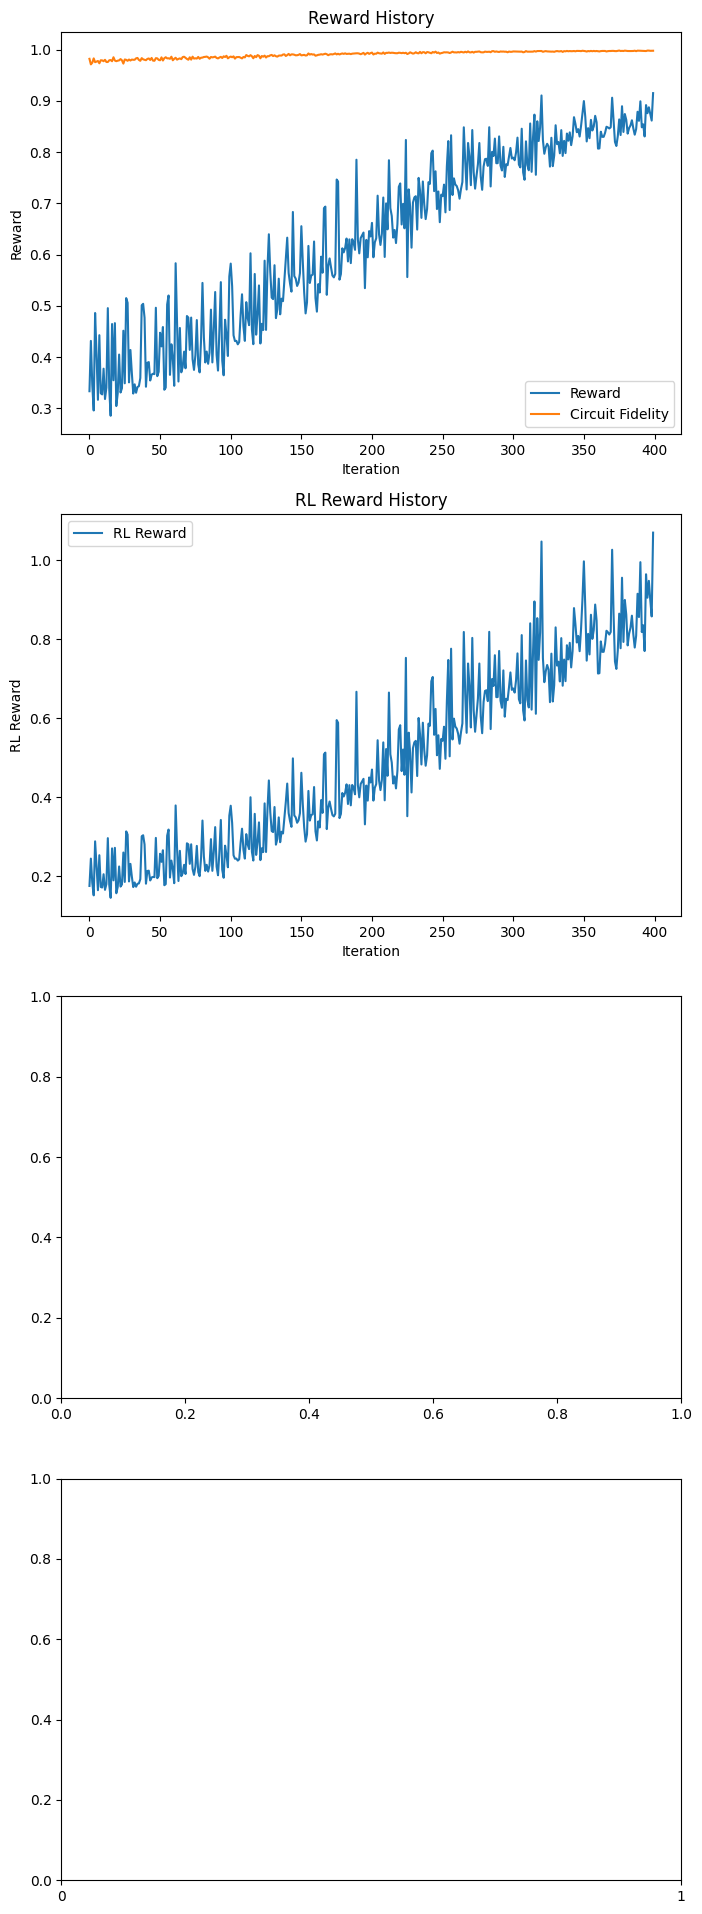

model saved to runs/PPO_ContextBuffer__Test PPO CleanRL__1__1747207219/Test PPO CleanRL.cleanrl_model


In [47]:
ppo_agent.run_training()

In [48]:
NUM_EVAL = 20
import torch

action_list = []
obs_list = []
reward_list = []

for n in range(NUM_EVAL):
    obs, _ = ppo_agent.env.reset()
    obs_list.append(obs)
    batch_obs = np.tile(obs, (32, 1))
    with torch.no_grad():
        batch_action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            torch.Tensor(batch_obs)
        )
    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        batch_action.numpy()
    )
    reward_list.append(np.mean(reward))
    mean_action = np.mean(batch_action.numpy(), axis=0)
    action_list.append(mean_action)

Sampled angles:  [0.         0.         0.2164929  0.         1.47701588 0.        ]
Environment Observation: [-0.86217634 -0.05970249]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9976491304151731
Reward (avg): 0.8699714375478971 Std: 0.06519839822324694
obs: [-0.86217634 -0.05970249]
reward: [0.93561586 0.63665447 1.06095929 0.62285157 0.73356138 0.72226828
 1.53422736 0.72066435 0.85018142 0.90313822 1.03018539 0.7770996
 1.15013734 0.81363067 0.77701592 0.965376   0.77110508 1.45431379
 0.72269937 1.23856097 0.91972679 0.90155175 0.78296798 1.13658283
 0.64545563 0.59288443 2.11377814 1.13934472 1.50047404 0.8158455
 1.26081708 0.87760426]
Sampled angles:  [0.         0.         1.57032666 0.         0.6232791  0.        ]
Environment Observation: [-2.98998108e-04 -6.03208200e-01]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9975203730340991
Reward (avg): 0.9050450909440346 Std: 0.06949879621294809
obs: [-2.98998108e-04 -6.03208200e-01]
reward: [1.38424298 1.23894662 1.13811453 0.78785223 1.2420538  1.31975402
 1.93464185 1.43689434 0.65582454 1.0061157  1.38583296 1.48936558
 0.97020686 0.7882655  1.37521788 1.25129265 0.69294012 0.73079604
 0.82026052 1.66948678 1.11455634 1.18869643 1.35780773 1.53540888
 0.91760452 0.96458014 0.86575469 0.53023229 1.52061409 0.67954629
 1.29397696 1.2027811 ]
Sampled angles:  [0.         0.         0.15642563 0.         1.36588285 0.        ]
Environment Observation: [-0.90041635 -0.13045197]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9975695989398856
Reward (avg): 0.8633405325880592 Std: 0.07059312442359661
obs: [-0.90041635 -0.13045197]
reward: [1.16505542 0.81620986 0.82713326 0.56253587 0.59504426 1.08724743
 0.73901282 0.80364271 1.46491564 0.88590064 0.87877318 1.1435851
 0.95923267 0.99468301 1.2001987  0.79268134 1.05409962 0.8486826
 1.33044686 1.01254377 0.94431215 0.69440788 0.93798666 1.04991775
 0.63130273 0.8456001  0.76081195 0.87197497 1.01665413 0.45702583
 1.58920865 0.69720738]
Sampled angles:  [0.         0.         2.55693925 0.         0.908511   0.        ]
Environment Observation: [ 0.62779808 -0.42162394]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9914490332780077
Reward (avg): 0.8418325704126726 Std: 0.10544907355137789
obs: [ 0.62779808 -0.42162394]
reward: [1.29417378 1.11242152 0.56969524 1.0889668  1.21473753 0.50311578
 0.54993039 1.12930205 1.20004795 1.03361481 1.167844   0.81084281
 1.47273623 0.67993    0.54634654 1.20396982 0.36934713 1.01173804
 0.76272637 1.01749981 0.43776558 0.71198617 1.27867985 1.20084059
 0.7347251  0.78834965 0.49399553 1.18030533 0.56190548 0.96925684
 0.94325822 0.72861586]
Sampled angles:  [0.         0.         2.43507824 0.         2.82580798 0.        ]
Environment Observation: [0.55021896 0.79896523]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.993331380954558
Reward (avg): 0.6321996167462929 Std: 0.12818447134399646
obs: [0.55021896 0.79896523]
reward: [0.34368325 0.40662518 1.29608304 0.56487447 0.56301749 0.21838261
 0.49205534 0.63885253 0.44259612 0.25108065 0.30799805 0.58618053
 0.38018788 0.36599776 0.40990107 0.78649096 0.64046748 0.39880348
 0.43461712 0.40485735 0.65243279 0.43688749 0.57549972 0.31211009
 0.47326495 0.18977804 0.27770789 0.70140693 0.4053507  0.36230607
 0.3774433  0.38520333]
Sampled angles:  [0.         0.         0.62567564 0.         1.37926615 0.        ]
Environment Observation: [-0.60168251 -0.1219319 ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9972267878886539
Reward (avg): 0.8700701515300917 Std: 0.09487145498656539
obs: [-0.60168251 -0.1219319 ]
reward: [0.54395549 1.27500907 1.09504172 1.23389862 0.75418263 1.35852089
 1.57338629 0.57907895 0.92038617 1.24968799 1.23673598 1.29428388
 1.31997669 1.06818288 1.74301793 0.78735777 1.43232203 1.05715506
 0.60168142 0.64940058 1.04311205 0.36039801 0.84267773 1.17488057
 0.73125305 1.10000427 0.67936541 0.69762285 0.75749472 1.48504144
 0.93357266 0.62888421]
Sampled angles:  [0.         0.         2.03637745 0.         2.10946835 0.        ]
Environment Observation: [0.29639815 0.34292926]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9901534918988826
Reward (avg): 0.732308986674235 Std: 0.1478533798750284
obs: [0.29639815 0.34292926]
reward: [0.29381903 0.78702747 0.56592586 0.85639849 0.4518993  0.34570518
 0.96313029 0.30242252 1.21439105 0.53230666 0.77963147 0.93155472
 0.36565816 0.70398162 0.76820701 0.65145985 1.0804536  0.70945982
 0.56198404 0.64870966 0.46942512 0.35973925 0.30462179 0.60771558
 1.18800864 1.03693687 0.83478629 0.73732559 0.38494198 0.72628616
 0.32945117 0.25040663]
Sampled angles:  [0.         0.         3.11950842 0.         2.39698394 0.        ]
Environment Observation: [0.98594074 0.52596737]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9919915432347077
Reward (avg): 0.538879766208108 Std: 0.1272853417723552
obs: [0.98594074 0.52596737]
reward: [0.54707737 0.31759698 0.29372386 0.48332496 0.28453912 0.29270639
 0.28293405 0.60126449 0.19290695 0.17810385 0.3207655  0.1931818
 0.49340546 0.62872139 0.30047188 0.32044646 0.34788611 0.15572816
 0.47242715 0.47223763 0.40324015 0.35288867 0.19471588 0.17392658
 0.51186962 0.32323218 0.4970599  0.34580634 0.24894561 0.45095579
 0.30730504 0.33492045]
Sampled angles:  [0.         0.         0.50636381 0.         2.13649927 0.        ]
Environment Observation: [-0.67763879  0.36013768]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9972920334720219
Reward (avg): 0.8676175264242567 Std: 0.06544564631298526
obs: [-0.67763879  0.36013768]
reward: [0.85728296 0.83308961 1.05951352 1.07933911 0.65060296 0.81216038
 0.75575432 0.69575591 1.27356216 0.81609419 0.69403925 0.82905746
 1.28413305 0.9241748  0.80559167 0.76239348 0.73115468 1.62088869
 0.92884122 0.706355   1.95786915 0.60361082 0.83251693 1.32213319
 1.31197382 0.85029968 0.58758227 0.85703375 0.81967268 1.98692998
 0.79879223 1.08883065]
Sampled angles:  [0.         0.         0.49188157 0.         2.04312154 0.        ]
Environment Observation: [-0.68685846  0.30069157]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.997031716074736
Reward (avg): 0.8711683126877943 Std: 0.07706194371340049
obs: [-0.68685846  0.30069157]
reward: [0.90109999 0.6922706  0.77029477 1.12959182 1.56037503 0.663452
 0.58605181 0.82279846 0.90819521 1.07237817 2.13489337 1.0053511
 0.72298585 0.85276865 0.86268383 0.80330049 1.39119818 1.1217421
 0.81397962 0.60699581 1.19788444 0.41285089 1.17598898 0.87550734
 1.63740685 0.85338027 0.95905148 1.11141914 1.23793478 0.77263665
 0.92683387 1.02097065]
Sampled angles:  [0.         0.         2.83246661 0.         1.52647533 0.        ]
Environment Observation: [ 0.80320425 -0.02821562]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9920657267165632
Reward (avg): 0.7034923164113625 Std: 0.13539286929809116
obs: [ 0.80320425 -0.02821562]
reward: [0.65405699 0.23100689 0.45770393 0.39866308 0.45785653 0.82060662
 0.38696005 0.37726748 0.50820887 0.42053292 0.35400018 0.80940984
 0.68455618 0.44719893 0.49708928 0.43594704 0.82542873 0.32071562
 0.48828943 1.3162274  0.67267234 0.75088039 0.31002095 0.2722406
 0.49631619 1.052711   0.97341992 0.61030744 1.10330431 0.61631173
 0.5220955  0.56787528]
Sampled angles:  [0.         0.         2.70553463 0.         0.35292779 0.        ]
Environment Observation: [ 0.72239684 -0.77531919]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.992901511600963
Reward (avg): 0.8161792406116768 Std: 0.09233608769183708
obs: [ 0.72239684 -0.77531919]
reward: [1.21593828 0.84288474 0.58368981 0.87953432 0.59252756 1.16490783
 0.43006376 0.84035222 0.62887568 0.39342567 0.9986302  0.6549234
 0.85575301 0.64030745 0.80570414 0.53905328 0.83698169 0.86204137
 0.40378365 1.53550353 0.76614173 0.80464091 0.74123597 0.74402545
 0.93269495 1.1432054  0.84355337 0.56605459 0.7090918  0.83174834
 0.59981866 1.11748272]
Sampled angles:  [0.         0.         1.25553486 0.         0.849914   0.        ]
Environment Observation: [-0.20070169 -0.45892794]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9972454228599539
Reward (avg): 0.9066131756843657 Std: 0.061298129325668055
obs: [-0.20070169 -0.45892794]
reward: [2.69204426 1.26512288 1.03567725 0.92864349 0.85296915 1.38952415
 0.98086283 0.677261   0.77702661 0.66479474 1.14837728 1.310596
 1.50192032 0.8306258  0.73344103 1.18540173 1.05297588 1.2546263
 1.35895376 1.72981292 0.79240578 1.35005101 1.06107303 1.53236086
 1.4054748  1.68880474 1.14580377 0.89207173 0.6337452  0.89124399
 1.11092857 1.17332861]
Sampled angles:  [0.         0.         2.80586808 0.         0.07664607 0.        ]
Environment Observation: [ 0.7862711 -0.9512056]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9943219790142922
Reward (avg): 0.8265533638926255 Std: 0.11130266851817873
obs: [ 0.7862711 -0.9512056]
reward: [0.48129232 0.82275244 0.64599447 1.58512077 0.57991085 0.89137577
 1.04130141 0.72820729 0.32203827 1.19751215 1.3900631  0.55148796
 0.89077254 0.70385721 1.51913673 1.14430945 0.76845692 1.19801496
 0.53158668 0.42907375 0.79705321 0.67623704 1.29922584 1.01770979
 0.7453564  0.54217032 0.58195277 0.98009056 1.49123561 0.78099013
 1.04767497 0.49323845]
Sampled angles:  [0.         0.         0.12685697 0.         2.59708811 0.        ]
Environment Observation: [-0.91924035  0.65335764]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9964679811608821
Reward (avg): 0.7988877515739297 Std: 0.10608728730188853
obs: [-0.91924035  0.65335764]
reward: [0.48642136 0.46993024 0.47232523 0.9245202  0.50919957 0.63551579
 1.28634065 0.49822724 0.75442225 0.61330009 0.475223   1.0852405
 0.59677449 1.203591   1.06837649 0.81155192 0.77190756 0.73315474
 0.49295962 0.9357907  1.08739498 1.39328367 0.52368976 0.42613712
 0.82252464 0.83954388 0.82816531 0.81281304 0.75674915 1.05354979
 0.37400466 0.85208119]
Sampled angles:  [0.         0.         2.01814332 0.         2.44459109 0.        ]
Environment Observation: [0.28478994 0.55627502]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9911807680944271
Reward (avg): 0.7018581854302011 Std: 0.12333892593761914
obs: [0.28478994 0.55627502]
reward: [0.51891188 0.42493048 0.5045379  0.42513931 0.4308739  0.55223993
 0.416522   0.62495047 1.09278424 0.49590526 0.87995453 0.76374715
 0.79352875 0.34756939 0.39174412 0.65446877 0.32468642 0.75029714
 0.4941221  0.4758922  0.97168731 0.24636409 0.3730108  0.64722762
 0.26405612 0.55923349 0.73853154 0.60970534 0.53412644 0.35125257
 0.75102728 0.77550975]
Sampled angles:  [0.         0.         2.36703013 0.         1.76161428 0.        ]
Environment Observation: [0.50689818 0.12147848]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9893154325952453
Reward (avg): 0.7297157384113432 Std: 0.14001293410029816
obs: [0.50689818 0.12147848]
reward: [0.64512426 0.44812033 0.93429149 0.43952588 0.45500158 0.69485289
 0.82203481 0.43133175 0.75302029 0.94206754 0.40620724 0.53357611
 0.9773366  0.24021679 0.38059716 0.4061943  0.97120842 1.33363694
 0.50225766 0.4540843  0.23785078 0.44817038 0.2880924  0.64621108
 0.53055105 0.87102348 0.7504398  0.56822967 0.60101256 1.2457
 0.61306567 0.90556761]
Sampled angles:  [0.         0.         2.03076828 0.         0.53542322 0.        ]
Environment Observation: [ 0.29282724 -0.65913899]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9964780133792598
Reward (avg): 0.8949322388045419 Std: 0.08252738771950001
obs: [ 0.29282724 -0.65913899]
reward: [0.75652432 0.91890071 0.79791389 1.66298099 1.6381001  0.99306963
 1.27126427 1.3792531  1.3100905  0.56306227 0.83915899 1.42790578
 1.04077074 1.11724974 1.04621752 1.19508959 1.31907111 0.88035358
 1.05272714 0.99511131 1.50167106 1.37282924 0.7803508  1.09271297
 0.87990216 1.28845331 0.36488715 0.85325487 1.65183386 0.8779777
 0.70827024 1.35331022]
Sampled angles:  [0.         0.         0.64415719 0.         2.72759051 0.        ]
Environment Observation: [-0.5899168   0.73643805]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9950574923441968
Reward (avg): 0.7755178074020517 Std: 0.14839967081249233
obs: [-0.5899168   0.73643805]
reward: [0.19612069 0.92734187 0.99918675 0.32163661 0.57375522 0.94018432
 0.79447584 0.98504602 0.47090967 0.89578291 1.3404255  0.42670599
 0.33100414 0.97258819 1.10558594 0.42573746 0.67586106 0.56997613
 1.04218293 0.57492998 0.57504668 0.38919626 1.57645357 1.07789687
 0.84961767 1.58466239 0.59278451 0.8482956  0.45194654 0.6558385
 0.41456912 0.82692041]
Sampled angles:  [0.         0.         0.17995028 0.         2.17348574 0.        ]
Environment Observation: [-0.88544009  0.383684  ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9975087597712382
Reward (avg): 0.8580074215152703 Std: 0.09063184664643507
obs: [-0.88544009  0.383684  ]
reward: [0.81601615 1.16838694 0.87820907 0.93413152 1.0630912  1.1478729
 1.08603602 0.71215381 0.77668533 0.41311119 0.77393897 1.03556751
 0.92773465 0.68154592 0.62283133 0.8427408  0.85130518 1.43360948
 0.7455245  0.43465051 0.72447883 0.53346947 1.26476083 0.57798589
 0.88276387 1.35829685 1.12882691 0.82161591 1.75839673 1.6492271
 1.24282498 1.01462721]


/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_91054/3013701159.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


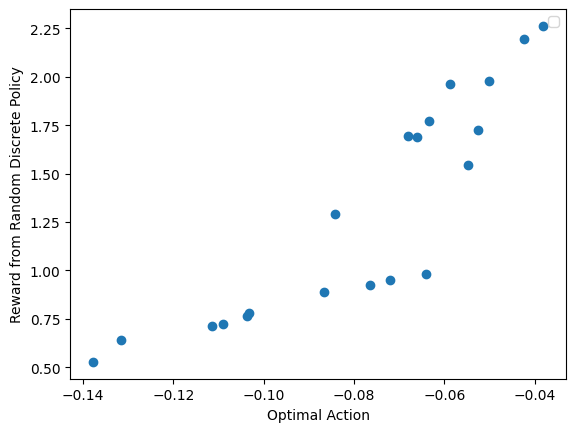

In [86]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[2, 4], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1)

plt.scatter(optimal_action, reward_list)
plt.xlabel('Optimal Action')
plt.ylabel('Reward from Random Discrete Policy')
plt.legend()
plt.show()

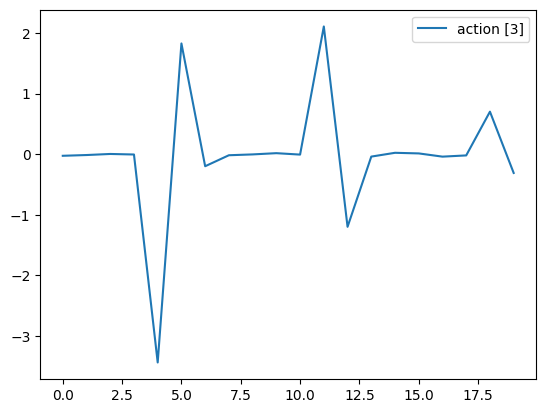

In [87]:
action_arr = np.array(action_list)
action_arr = action_arr.reshape(7, -1)

for i in range(len(action_arr)):
    if i == 3:
        plt.plot(action_arr[i], label=f'action [{i}]')
plt.legend()
plt.show()

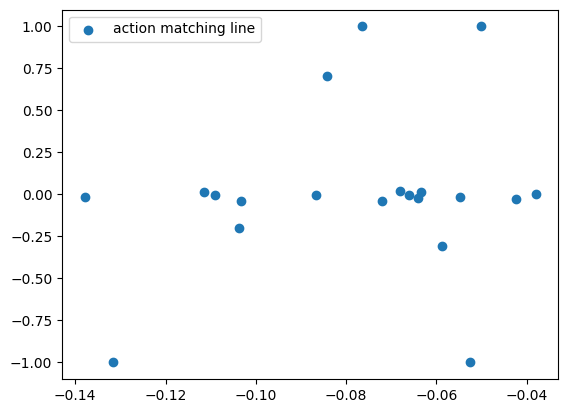

In [88]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[2, 4], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1)

action_relevant = action_arr[3]

plt.scatter(optimal_action, np.clip(action_relevant, a_min=-1., a_max=1.), label='action matching line')
plt.legend()
plt.show()

In [89]:
ppo_agent.context_history

[(1, array([-0.16595599,  0.44064899])),
 (1, array([-0.99977125, -0.39533485])),
 (2, array([0.96351328, 0.78604242])),
 (2, array([0.51869759, 0.30224112])),
 (3, array([ 0.58074705, -0.56500156])),
 (3, array([-0.59958201,  0.36088013])),
 (4, array([ 0.04559206, -0.67612421])),
 (4, array([ 0.89795404, -0.88110185])),
 (5, array([0.96151755, 0.37312636])),
 (5, array([ 0.83989446, -0.86120808])),
 (6, array([-0.68637962, -0.22276715])),
 (6, array([ 0.00531339, -0.66873483])),
 (7, array([-0.04283956, -0.83730619])),
 (7, array([-0.15631585, -0.69895618])),
 (8, array([-0.82365264, -0.52984473])),
 (8, array([-0.07679584, -0.60281699])),
 (9, array([-0.33574141,  0.26698015])),
 (9, array([0.34682874, 0.25640249])),
 (10, array([-0.13232035, -0.88128555])),
 (10, array([-0.0145548 , -0.06973211])),
 (11, array([ 0.66031305, -0.51980969])),
 (11, array([0.26324149, 0.42147914])),
 (12, array([0.13031305, 0.56270671])),
 (12, array([ 0.89739964, -0.52274398])),
 (13, array([0.1539556

In [90]:
arr_context_history = [tup[1] for tup in ppo_agent.context_history]

In [92]:
arr_context_history = np.array(arr_context_history)

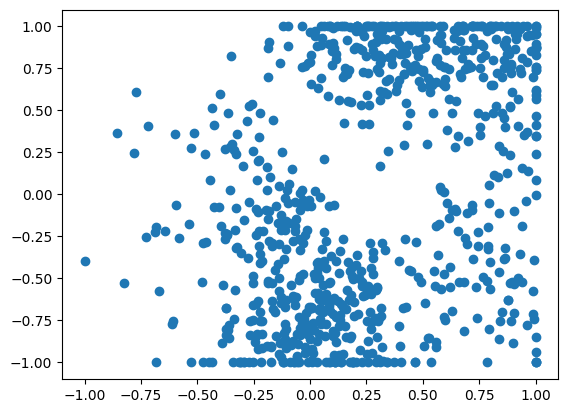

In [96]:
plt.scatter(arr_context_history[:,0], arr_context_history[:,1])
plt.show()

In [97]:
ppo_agent.context_buffer

deque([array([ 0.10619722, -0.61551116]),
       array([ 0.13414905, -0.74905663]),
       array([-0.2799765 ,  0.43519099]),
       array([0.94388785, 1.        ]),
       array([0.19282882, 0.98849365]),
       array([-0.100027  , -0.04907671]),
       array([ 0.0385331, -0.6241202]),
       array([-0.6132612, -0.7731658]),
       array([-0.02031739, -0.90850852]),
       array([0.23504669, 0.72672121]),
       array([-0.31687566, -1.        ]),
       array([0.07989888, 1.        ]),
       array([0.82640957, 1.        ]),
       array([-0.11696827, -0.82605574]),
       array([0.20592003, 1.        ]),
       array([ 0.07772967, -0.6258654 ]),
       array([-0.42528138,  0.41616216]),
       array([-0.18999862,  0.02648732]),
       array([-0.35558355,  0.28065835]),
       array([-0.25149187, -0.74515565]),
       array([-0.1083617, -0.7985142]),
       array([-0.43506494,  0.51768172]),
       array([-0.47560797, -1.        ]),
       array([0.71183925, 0.75732465]),
       array

In [114]:
sample_context_list = []

for i in range(100):
    sample_context = ppo_agent.sample_context(warmup=False)
    sample_context_list.append(sample_context)

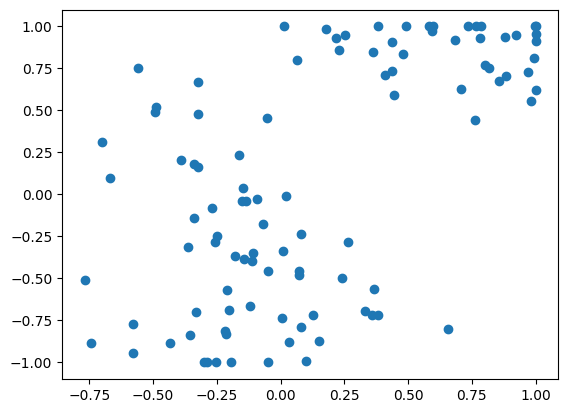

In [115]:
sample_context_arr = np.array(sample_context_list)
plt.scatter(sample_context_arr[:, 0], sample_context_arr[:, 1])
plt.show()

In [116]:
arr_data = np.array(ppo_agent.context_buffer)

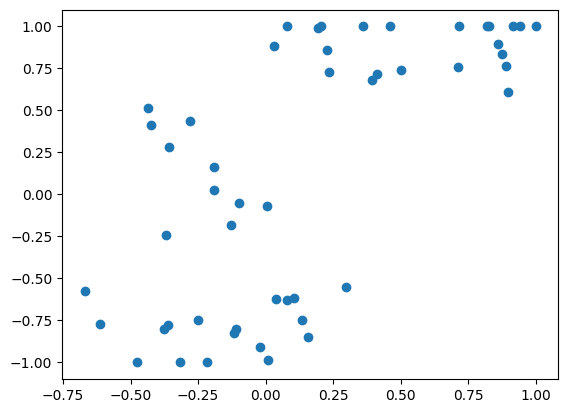

In [121]:
plt.scatter(arr_data[:,0], arr_data[:, 1])

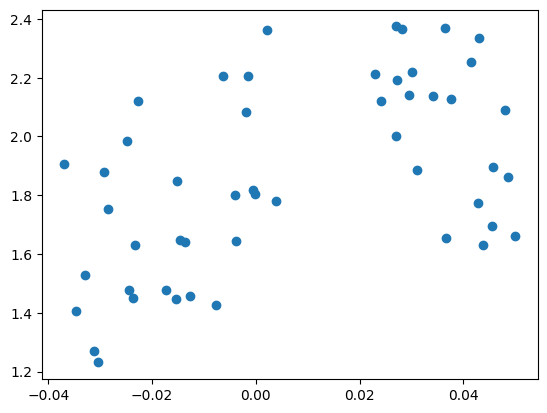

In [130]:
obs_data = arr_data.sum(axis=1) * 0.025

plt.scatter(obs_data, c_rewards)

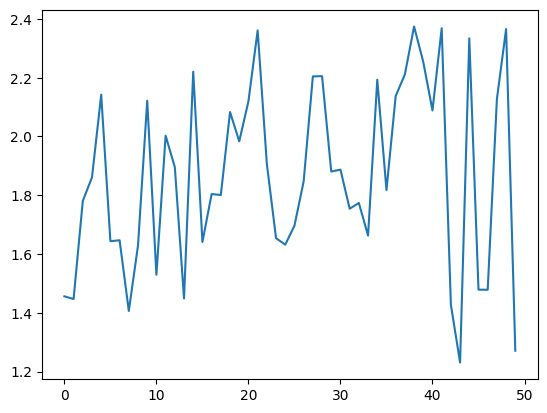

In [125]:
c_rewards = ppo_agent.context_rewards

plt.plot(c_rewards)

In [127]:
len(c_rewards)

50